In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sin, cos, sqrt, atan2, radians
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error
import optuna

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 1000)

### 0. Lectura del dataset

In [29]:
# Carga el csv en un dataframe
df = pd.read_csv('dataset_priv.csv', header=0, low_memory=False)
df = df.sample(frac=1).reset_index(drop=True)
df.loc[:10]

codPaq  mes_alta  diasem_alta  turno  num_envios  alto  ancho  ...  osp  distancia  tiempo_entrega    x_dest     y_dest min_reparto  dist_reparto
0   PQ936A0785601030141008G        12            2      0           5     0      0  ...    0      0.689           124.8 -5.973835  37.401078         571         1.155
1   PQ7DDD0710120540141300K         1            2      0          25     0      0  ...    0      0.653           214.8 -5.940164  37.483801         474        33.609
2   PQ936A0706238560141006D         4            3      0           2     0      0  ...    0      0.523           175.0 -5.957919  37.376734         526         0.563
3   PQ8BF50788525980141015L         3            3      0           6     0      0  ...    0      2.904           141.7 -5.986135  37.415557         607         3.002
4   PQ6AA40714684990141960S        10            2      0           1     0      0  ...    0      0.797            82.3 -6.073430  37.381333         521         0.797
5   PQ8BF50773576310141018D         2            1      1           7     0      0  ...    0      0.736            49.8 -5.981251  37.379525         938         1.072
6   PQ936A0763006570141020W        11            1      0          45     0      0  ...    0      1.754            94.5 -5.925199  37.393472         566         8.584
7   PQ8H840714266680141928B         6            2      0           4     0      0  ...    0      0.556            70.0 -6.064546  37.323081         564         0.556
8   PQ8BF50796721050141650D         3            3      0           4     0      0  ...    0      0.465            68.1 -5.100085  37.071848         548         0.465
9   PQ7RTR0407293750141006Q         1            1      0           9     5     43  ...    0      0.654           253.6 -5.959440  37.370757         530         1.225
10  PQ84VQ0200007820141808A         5            4      0           3    31     23  ...    0      2.708           205.3 -6.148554  37.397793         578         2.768

[11 rows x 24 columns]

### 1. Análisis Exploratorio de los Datos (EDA)

In [7]:
# Valores totales
df.count()

codPaq            461476
mes_alta          461476
diasem_alta       461476
turno             461476
num_envios        461476
alto              461476
ancho             461476
largo             461476
peso              461476
pv                461476
cp                461476
unidad            461476
tipo              461476
ur                461476
ud                461476
use               461476
ot                461476
osp               461476
distancia         461476
tiempo_entrega    461476
x_dest            461476
y_dest            461476
min_reparto       461476
dist_reparto      461476
dtype: int64

In [8]:
# Valores distintos por cada columna
print("REGISTROS TOTALES: " + str(df.codPaq.count()) + "\n")
for column in df.columns:
    n = df[column].nunique()
    print(column + ": " + str(n))

REGISTROS TOTALES: 461476

codPaq: 461476
mes_alta: 12
diasem_alta: 6
turno: 2
num_envios: 68
alto: 165
ancho: 134
largo: 175
peso: 5944
pv: 9556
cp: 238
unidad: 75
tipo: 5
ur: 2
ud: 2
use: 2
ot: 2
osp: 2
distancia: 12801
tiempo_entrega: 4219
x_dest: 115268
y_dest: 115271
min_reparto: 815
dist_reparto: 49303


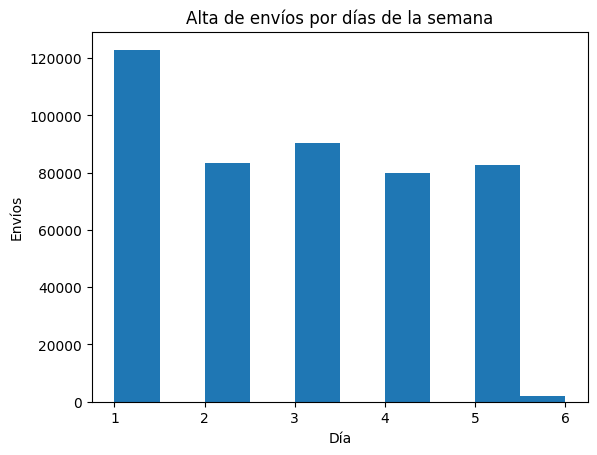

In [6]:
# Alta de envíos por días de la semana
plot_alta_dia_sem = df.diasem_alta.plot.hist(bins=10, title="Alta de envíos por días de la semana", xlabel="Día", ylabel="Envíos")

In [7]:
df.columns

Index(['codPaq', 'mes_alta', 'diasem_alta', 'turno', 'num_envios', 'alto', 'ancho', 'largo', 'peso', 'pv', 'cp', 'unidad', 'tipo', 'ur', 'ud', 'use', 'ot', 'osp', 'distancia', 'tiempo_entrega', 'x_dest', 'y_dest', 'min_reparto', 'dist_reparto'], dtype='object')

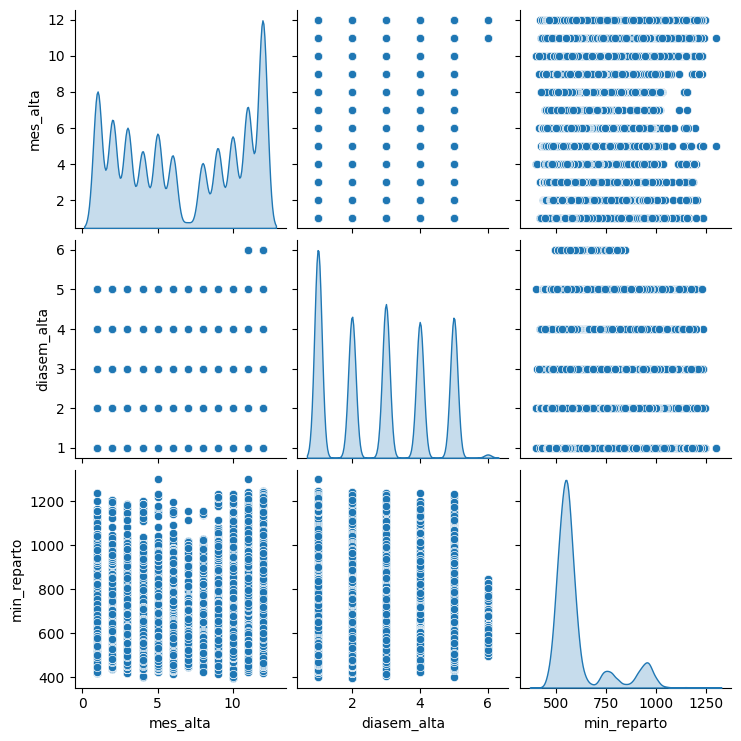

In [8]:
# Relación entre las variables de mes, día de la semana y tiempo en minutos de salida en reparto
sns.pairplot(df[["mes_alta", "diasem_alta", "min_reparto"]], diag_kind="kde")

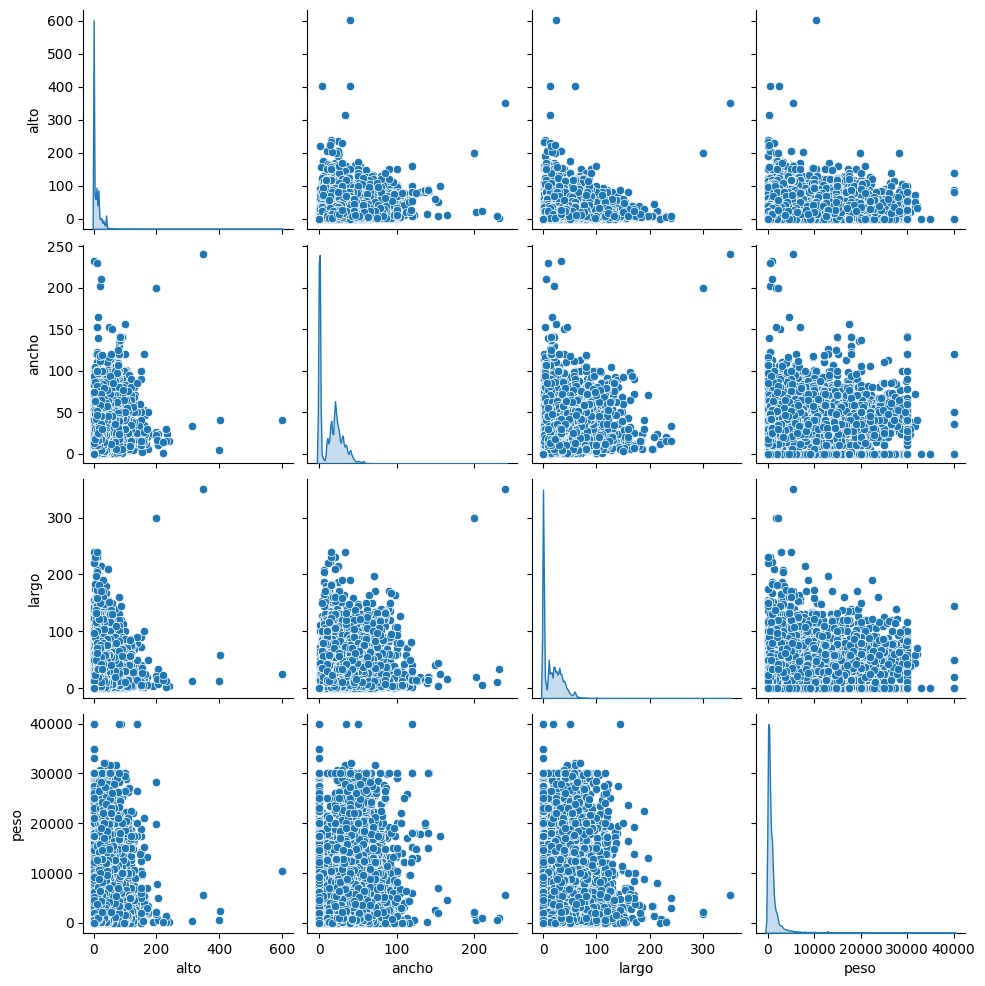

In [8]:
# Relación entre las variables de alto, ancho, largo y peso
sns.pairplot(df[["alto", "ancho", "largo", "peso"]], diag_kind="kde")

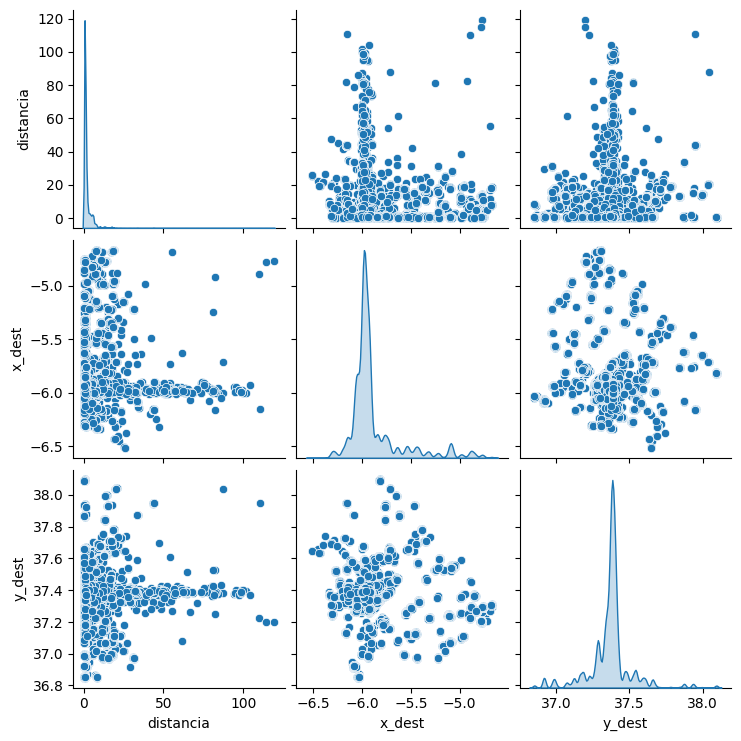

In [9]:
# Relación entre las variables de distancia y coordenadas de destino
sns.pairplot(df[["distancia", "x_dest", "y_dest"]], diag_kind="kde")

### 1.1 EDA (1 unidad)

In [77]:
# Selecciona una unidad
#cod_unidad = 4130494
cod_unidad = 4101796   # Unidad con más envíos
df1 = df.loc[df["unidad"] == cod_unidad]
print(df1.count())
df1.head()


codPaq            37661
mes_alta          37661
diasem_alta       37661
turno             37661
num_envios        37661
alto              37661
ancho             37661
largo             37661
peso              37661
pv                37661
cp                37661
unidad            37661
tipo              37661
ur                37661
ud                37661
use               37661
ot                37661
osp               37661
distancia         37661
tiempo_entrega    37661
x_dest            37661
y_dest            37661
min_reparto       37661
dist_reparto      37661
dtype: int64


codPaq  mes_alta  diasem_alta  turno  num_envios  alto  ancho  ...  osp  distancia  tiempo_entrega    x_dest     y_dest min_reparto  dist_reparto
12  PQ83220710684450141002Y         2            5      1          11     9     36  ...    0      5.903           338.4 -5.994228  37.401950         982         9.381
25  PQ9L9B0404941430141020A         8            5      1           5    24     45  ...    0      3.447           155.1 -5.915717  37.405448        1022         4.190
35  PQ8BRK0720248600141004M         2            3      0          14    25     27  ...    0      4.740            34.3 -5.986871  37.387313         556         6.118
49  PQ8H3H0401961400141011V         1            2      0           8    14     24  ...    0      5.919           229.0 -6.000909  37.371687         518        22.357
81  PQ46VJ0727068940141008X         2            1      1           3    11     36  ...    0      4.549           169.1 -5.980392  37.396718         890         7.910

[5 rows x 24 columns]

In [78]:
# Valores distintos por cada columna (1 unidad)
print("REGISTROS TOTALES (" + str(cod_unidad) + "): " + str(df1.codPaq.count()) + "\n")
for column in df1.columns:
    n = df1[column].nunique()
    print(column + ": " + str(n))

REGISTROS TOTALES (4101796): 37661

codPaq: 37661
mes_alta: 12
diasem_alta: 6
turno: 2
num_envios: 43
alto: 142
ancho: 116
largo: 155
peso: 4474
pv: 5885
cp: 27
unidad: 1
tipo: 1
ur: 1
ud: 1
use: 1
ot: 1
osp: 1
distancia: 5242
tiempo_entrega: 3633
x_dest: 11968
y_dest: 11974
min_reparto: 446
dist_reparto: 18695


In [79]:
# Códigos Postales (1 unidad)
cp = df1["cp"].unique()
print(cp)
print(len(cp))

[41002 41020 41004 41011 41008 41007 41015 41005 41010 41012 41013 41017
 41019 41003 41014 41009 41001 41006 41092 41018 41016 41071 41105 41070
 41106 41022 41000]
27


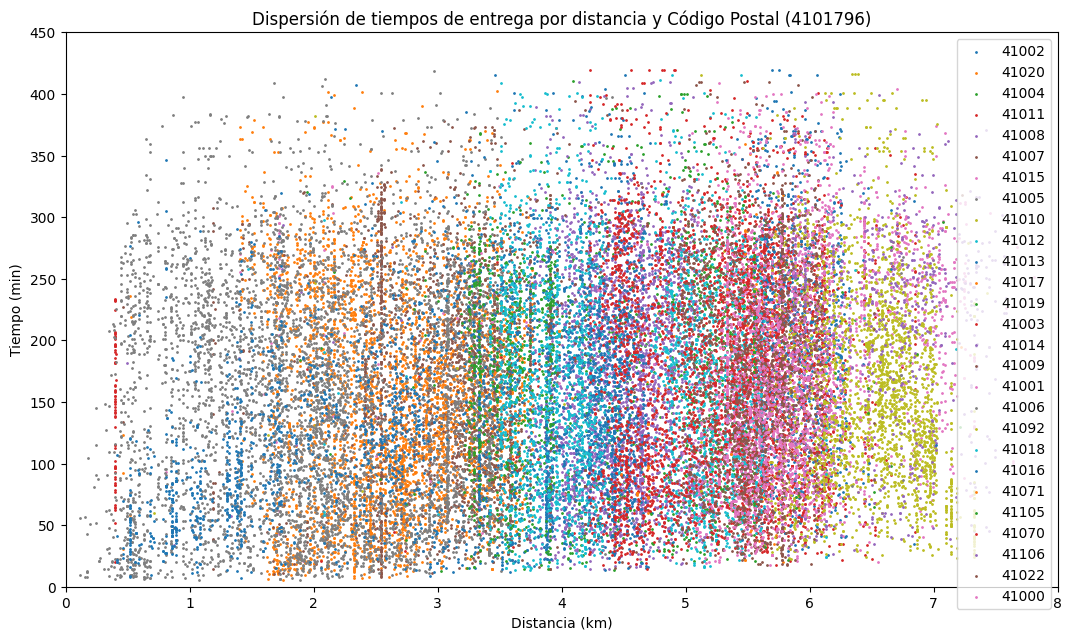

In [81]:
# Dispersión de tiempos de entrega por distancia y CP (1 unidad)
fig, ax = plt.subplots()
DPI = fig.get_dpi()
fig.set_size_inches(1280.0/float(DPI),720.0/float(DPI))
for k in range(len(cp)):
    df_cp = df1.loc[df1["cp"] == cp[k]]
    ax.scatter(df_cp.distancia, df_cp.tiempo_entrega, 1, label=cp[k])
ax.legend(loc='upper right')
ax.set(xlim=(0, 8))
ax.set(ylim=(0, 450))
plt.title("Dispersión de tiempos de entrega por distancia y Código Postal (" + str(cod_unidad) + ")")
plt.xlabel("Distancia (km)")
plt.ylabel("Tiempo (min)")
plt.show()

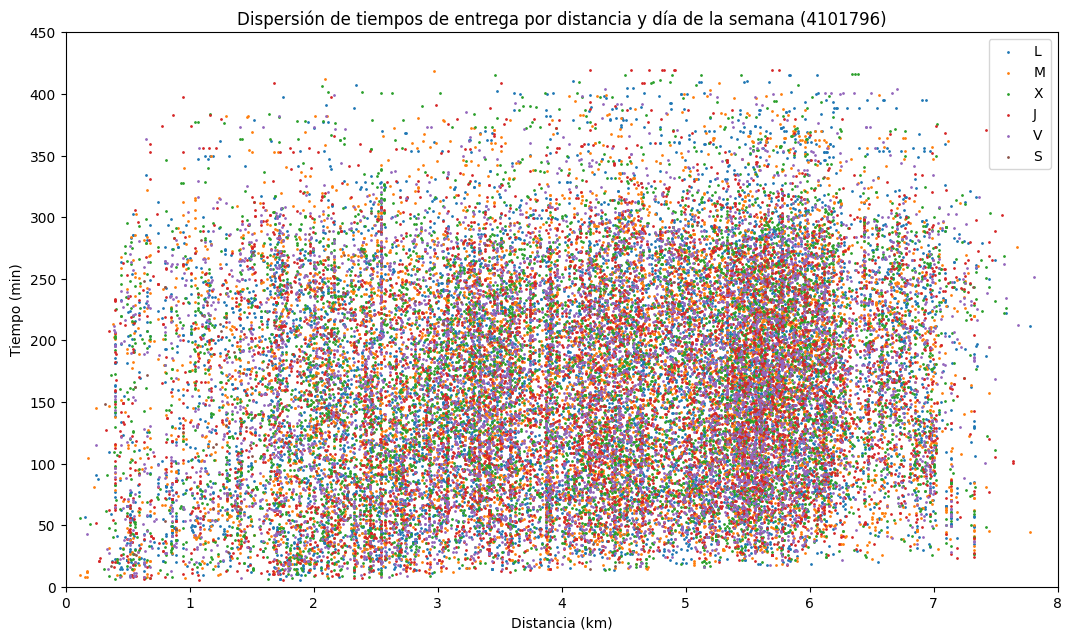

In [83]:
# Dispersión de tiempos de entrega por distancia y día de la semana (1 unidad)
diasem = ['L', 'M', 'X', 'J', 'V', 'S']

fig, ax = plt.subplots()
DPI = fig.get_dpi()
fig.set_size_inches(1280.0/float(DPI),720.0/float(DPI))
for k in range(6):
    df_dia = df1.loc[df1["diasem_alta"] == k+1]
    ax.scatter(df_dia.distancia, df_dia.tiempo_entrega, 1, label=diasem[k])
ax.legend(loc='upper right')
ax.set(xlim=(0, 8))
ax.set(ylim=(0, 450))
plt.title("Dispersión de tiempos de entrega por distancia y día de la semana (" + str(cod_unidad) + ")")
plt.xlabel("Distancia (km)")
plt.ylabel("Tiempo (min)")
plt.show()

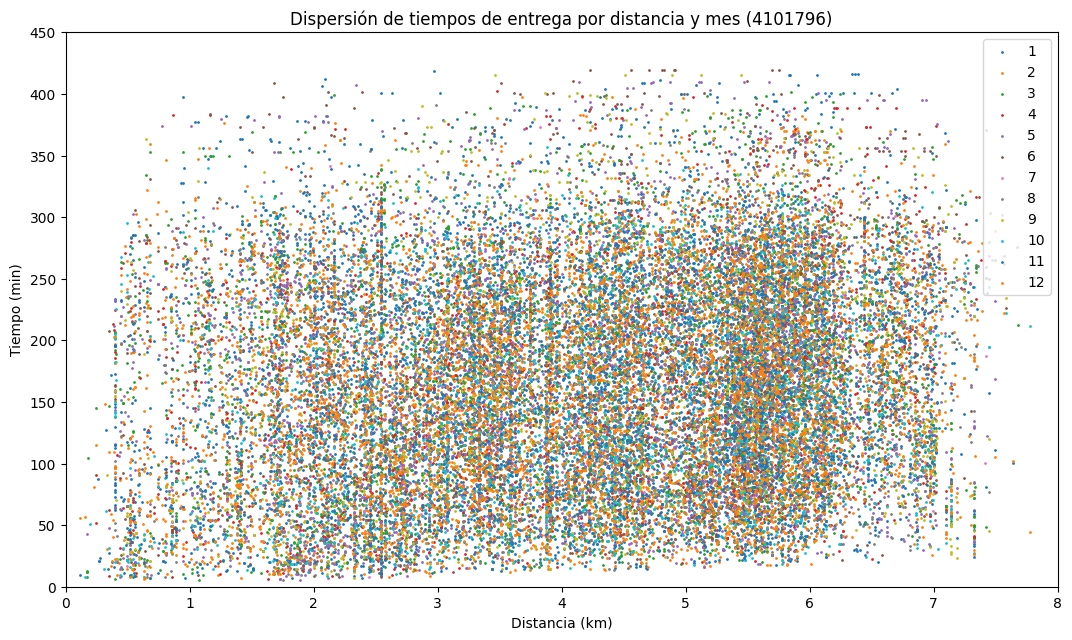

In [84]:
# Dispersión de tiempos de entrega por distancia y mes (1 unidad)
fig, ax = plt.subplots()
DPI = fig.get_dpi()
fig.set_size_inches(1280.0/float(DPI),720.0/float(DPI))
for k in range(12):
    df_mes = df1.loc[df1["mes_alta"] == k+1]
    ax.scatter(df_mes.distancia, df_mes.tiempo_entrega, 1, label=k+1)
ax.legend(loc='upper right')
ax.set(xlim=(0, 8))
ax.set(ylim=(0, 450))
plt.title("Dispersión de tiempos de entrega por distancia y mes (" + str(cod_unidad) + ")")
plt.xlabel("Distancia (km)")
plt.ylabel("Tiempo (min)")
plt.show()

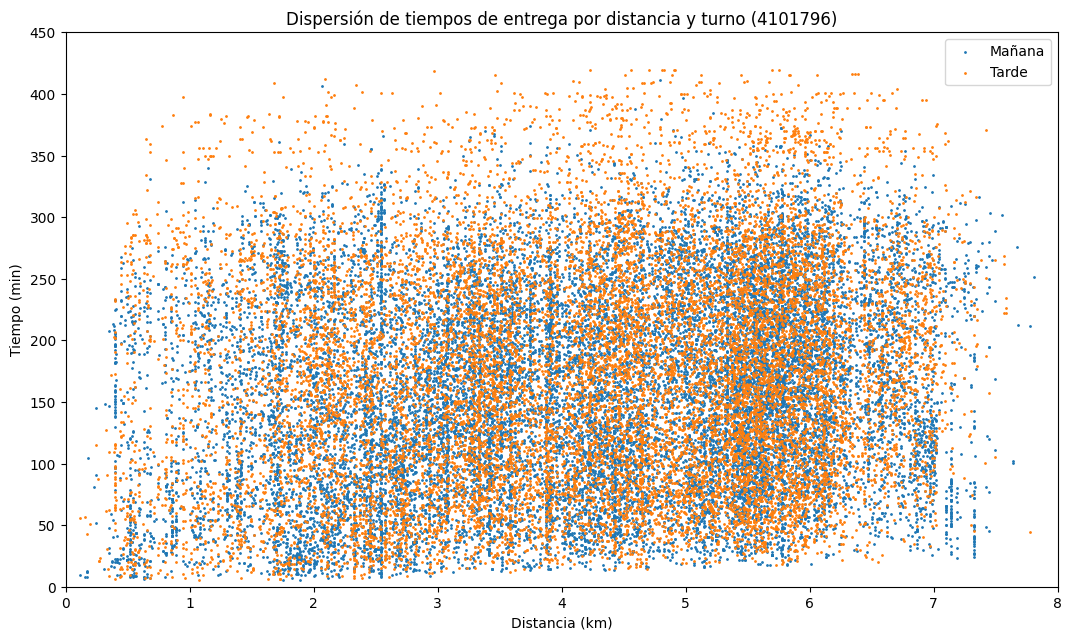

In [86]:
# Dispersión de tiempos de entrega por distancia y turno (1 unidad)
turno = ['Mañana', 'Tarde']

fig, ax = plt.subplots()
DPI = fig.get_dpi()
fig.set_size_inches(1280.0/float(DPI),720.0/float(DPI))
for k in range(2):
    df_turno = df1.loc[df1["turno"] == k]
    ax.scatter(df_turno.distancia, df_turno.tiempo_entrega, 1, label=turno[k])
ax.legend(loc='upper right')
ax.set(xlim=(0, 8))
ax.set(ylim=(0, 450))
plt.title("Dispersión de tiempos de entrega por distancia y turno (" + str(cod_unidad) + ")")
plt.xlabel("Distancia (km)")
plt.ylabel("Tiempo (min)")
plt.show()

In [87]:
# Recorre el dataframe añadiendo el rango del PV
df1 = df1.reset_index(drop=True)
for k in range(len(df1)):
    pv = df1.at[k,'pv']
    pv_rango = 0
    if pv == 0:
        pv_rango = 0
    elif pv <= 1:
        pv_rango = 1
    elif pv <= 10:
        pv_rango = 10
    elif pv <= 20:
        pv_rango = 20
    else:
        pv_rango = 100
    df1.at[k, 'pv_rango'] = pv_rango


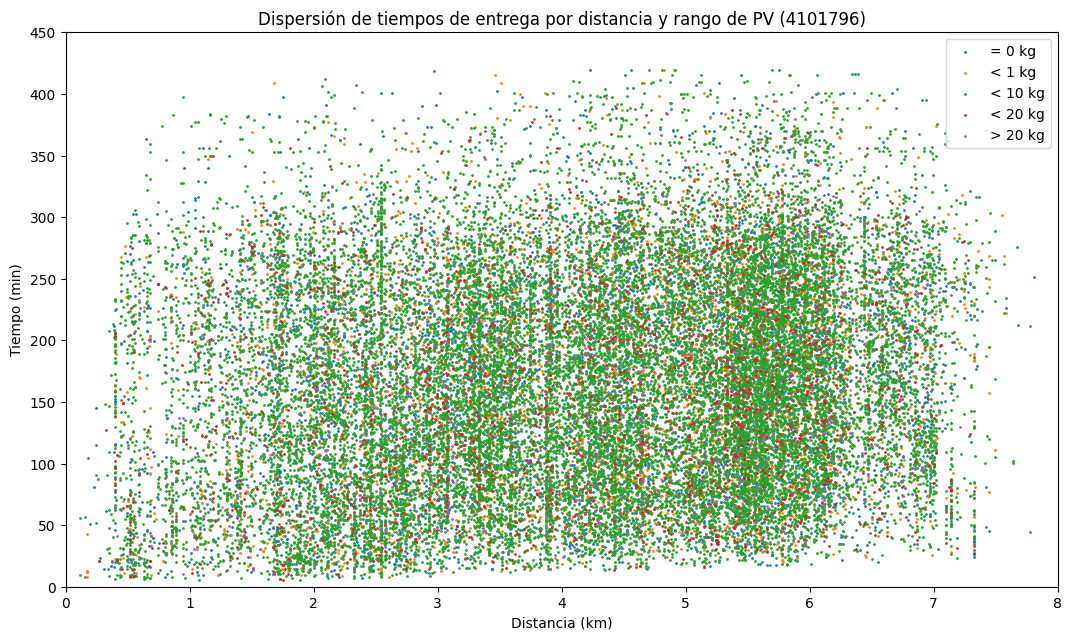

In [88]:
# Dispersión de tiempos de entrega por distancia y rango de PV
pv = ['= 0 kg', '< 1 kg', '< 10 kg', '< 20 kg', '> 20 kg']
pv_rango = [0, 1, 10, 20, 100]

fig, ax = plt.subplots()
DPI = fig.get_dpi()
fig.set_size_inches(1280.0/float(DPI),720.0/float(DPI))
for k in range(len(pv)):
    df_pv = df1.loc[df1["pv_rango"] == pv_rango[k]]
    ax.scatter(df_pv.distancia, df_pv.tiempo_entrega, 1, label=pv[k])
ax.legend(loc='upper right')
ax.set(xlim=(0, 8))
ax.set(ylim=(0, 450))
plt.title("Dispersión de tiempos de entrega por distancia y rango de PV (" + str(cod_unidad) + ")")
plt.xlabel("Distancia (km)")
plt.ylabel("Tiempo (min)")
plt.show()

In [374]:
# Recorre el dataframe añadiendo la velocidad media
df1 = df1.reset_index(drop=True)
for k in range(len(df1)):
    vel = df1.at[k, "distancia"] / (df1.at[k, "tiempo_entrega"]/60) if df1.at[k, "tiempo_entrega"] > 0 else 0
    df1.at[k, 'velocidad'] = vel

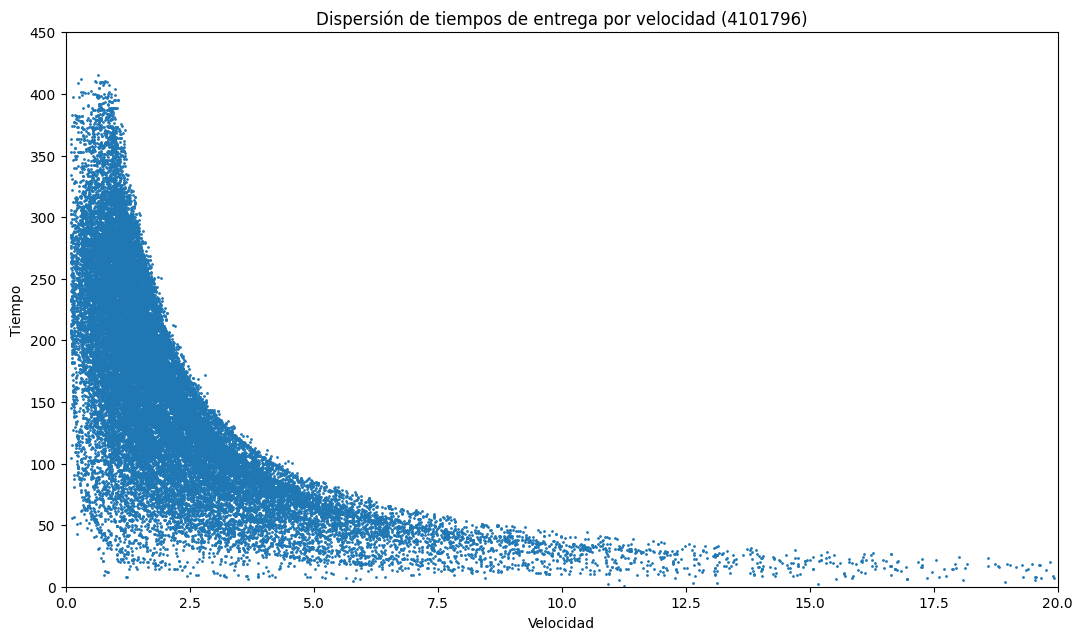

In [178]:
# Dispersión de tiempos de entrega por velocidad
fig, ax = plt.subplots()
DPI = fig.get_dpi()
fig.set_size_inches(1280.0/float(DPI),720.0/float(DPI))
ax.scatter(df1.velocidad, df1.tiempo_entrega, 1)
ax.set(xlim=(0, 20))
ax.set(ylim=(0, 450))
plt.title("Dispersión de tiempos de entrega por velocidad (" + str(cod_unidad) + ")")
plt.xlabel("Velocidad")
plt.ylabel("Tiempo")
plt.show()

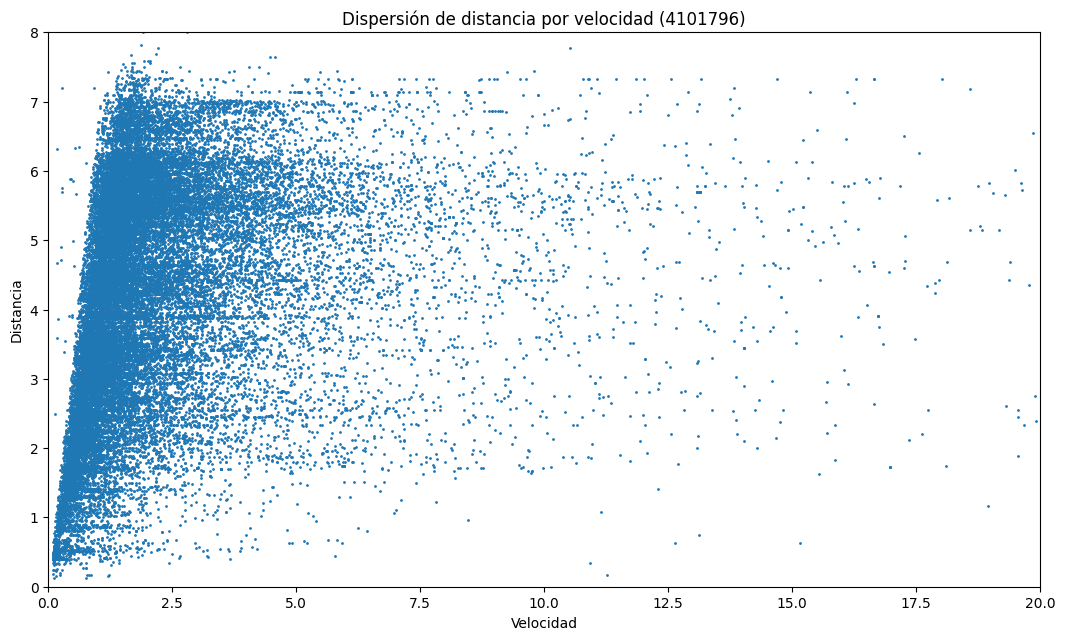

In [179]:
# Dispersión de distancia por velocidad
fig, ax = plt.subplots()
DPI = fig.get_dpi()
fig.set_size_inches(1280.0/float(DPI),720.0/float(DPI))
ax.scatter(df1.velocidad, df1.distancia, 1)
ax.set(xlim=(0, 20))
ax.set(ylim=(0, 8))
plt.title("Dispersión de distancia por velocidad (" + str(cod_unidad) + ")")
plt.xlabel("Velocidad")
plt.ylabel("Distancia")
plt.show()

In [286]:
# Columnas actuales
df1.columns

Index(['codPaq', 'mes_alta', 'diasem_alta', 'turno', 'num_envios', 'alto', 'ancho', 'largo', 'peso', 'pv', 'cp', 'unidad', 'tipo', 'ur', 'ud', 'use', 'ot', 'osp', 'distancia', 'tiempo_entrega', 'x_dest', 'y_dest', 'min_reparto', 'dist_parcial', 'orden_reparto', 'velocidad'], dtype='object')

In [375]:
# Elimina columnas que no aportan nada o están relacionadas (1 unidad)
list = ['codPaq', 'unidad', 'tipo', 'turno', 'ur', 'ud', 'use', 'ot', 'osp', 'velocidad']
df1 = df1.drop(columns=list)
df1

mes_alta  diasem_alta  num_envios  alto  ancho  largo   peso  ...  distancia  tiempo_entrega    x_dest     y_dest  min_reparto  dist_reparto  pv_rango
0             6            5           1    38     51     59  12650  ...      2.408           119.3 -5.960192  37.371163          526         2.408      20.0
1             2            3          22     0      0      0   1150  ...      5.505            67.1 -5.977213  37.414261          516         5.505       0.0
2             6            4          10     7     20     27   3600  ...      4.683           104.7 -5.979424  37.400538          495         4.855       1.0
3             3            4          10    40     22     11   1250  ...      4.581           326.5 -5.982045  37.394593          944        14.197      10.0
4             1            3           8    40     35     42   1700  ...      4.730           177.4 -5.974823  37.406202          570         7.544      10.0
...         ...          ...         ...   ...    ...    ...    ...  ...        ...             ...       ...        ...          ...           ...       ...
37626         1            1           7    14     33     40    900  ...      6.939           122.1 -6.012957  37.378714          519         9.928      10.0
37627         2            2          14    14     39     58   1350  ...      6.735           254.6 -5.974610  37.429734          516        29.462      10.0
37628         5            4          18     8     24     35   3150  ...      1.637            66.9 -5.952960  37.378883          529         2.781      10.0
37629        10            3          10     0      0      0    300  ...      4.433           293.5 -5.958521  37.413237          485        12.208       0.0
37630         4            3          13    31     21     12   2460  ...      1.711           168.9 -5.953314  37.374791          533         6.915      10.0

[37631 rows x 16 columns]

In [376]:
# Elegir quedarse con medidas o peso volumétrico
list = ['alto', 'largo', 'ancho']
#list = ["pv"]
df1 = df1.drop(columns=list)
df1

mes_alta  diasem_alta  num_envios         pv     cp  distancia  tiempo_entrega    x_dest     y_dest  min_reparto  dist_reparto  pv_rango
0             6            5           1  19.057000  41006      2.408           119.3 -5.960192  37.371163          526         2.408      20.0
1             2            3          22   0.000000  41009      5.505            67.1 -5.977213  37.414261          516         5.505       0.0
2             6            4          10   0.630000  41008      4.683           104.7 -5.979424  37.400538          495         4.855       1.0
3             3            4          10   1.613333  41003      4.581           326.5 -5.982045  37.394593          944        14.197      10.0
4             1            3           8   9.800000  41008      4.730           177.4 -5.974823  37.406202          570         7.544      10.0
...         ...          ...         ...        ...    ...        ...             ...       ...        ...          ...           ...       ...
37626         1            1           7   3.080000  41010      6.939           122.1 -6.012957  37.378714          519         9.928      10.0
37627         2            2          14   5.278000  41006      6.735           254.6 -5.974610  37.429734          516        29.462      10.0
37628         5            4          18   1.120000  41006      1.637            66.9 -5.952960  37.378883          529         2.781      10.0
37629        10            3          10   0.000000  41008      4.433           293.5 -5.958521  37.413237          485        12.208       0.0
37630         4            3          13   1.302000  41006      1.711           168.9 -5.953314  37.374791          533         6.915      10.0

[37631 rows x 12 columns]

In [377]:
# Calcula el mapa de correlaciones de variables (1 unidad)
corr = df1.corr().round(2)
corr

mes_alta  diasem_alta  num_envios    pv    cp  distancia  tiempo_entrega  x_dest  y_dest  min_reparto  dist_reparto  pv_rango
mes_alta            1.00         0.09       -0.02 -0.00  0.02       0.01           -0.03   -0.00   -0.01         0.02          0.05     -0.01
diasem_alta         0.09         1.00       -0.01 -0.00 -0.02       0.00           -0.01   -0.02   -0.02        -0.03          0.02      0.00
num_envios         -0.02        -0.01        1.00 -0.01 -0.01      -0.00            0.01   -0.00    0.01        -0.00          0.55     -0.02
pv                 -0.00        -0.00       -0.01  1.00  0.00      -0.01           -0.01    0.01   -0.00        -0.01         -0.01      0.19
cp                  0.02        -0.02       -0.01  0.00  1.00       0.01           -0.07    0.25    0.08        -0.08          0.03     -0.02
distancia           0.01         0.00       -0.00 -0.01  0.01       1.00            0.14   -0.78    0.11        -0.02          0.11      0.00
tiempo_entrega     -0.03        -0.01        0.01 -0.01 -0.07       0.14            1.00   -0.09    0.02         0.04          0.31     -0.02
x_dest             -0.00        -0.02       -0.00  0.01  0.25      -0.78           -0.09    1.00    0.10        -0.00         -0.04     -0.01
y_dest             -0.01        -0.02        0.01 -0.00  0.08       0.11            0.02    0.10    1.00        -0.01         -0.02     -0.00
min_reparto         0.02        -0.03       -0.00 -0.01 -0.08      -0.02            0.04   -0.00   -0.01         1.00          0.03     -0.01
dist_reparto        0.05         0.02        0.55 -0.01  0.03       0.11            0.31   -0.04   -0.02         0.03          1.00     -0.01
pv_rango           -0.01         0.00       -0.02  0.19 -0.02       0.00           -0.02   -0.01   -0.00        -0.01         -0.01      1.00

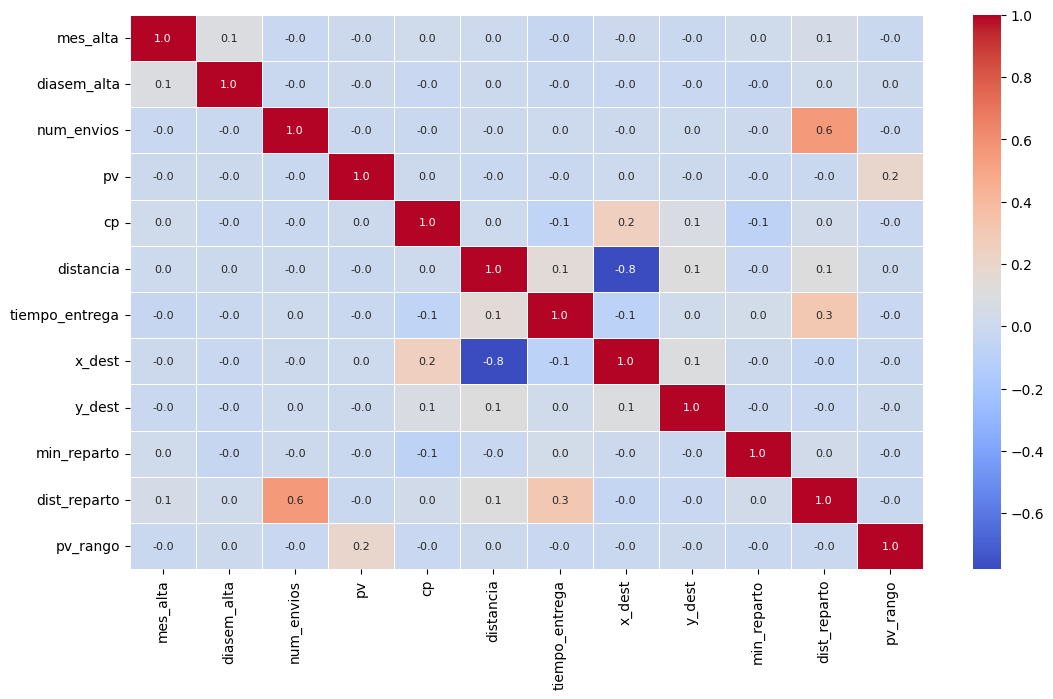

In [378]:
# Muestra la matriz de correlación (1 unidad)
fig, ax = plt.subplots()
DPI = fig.get_dpi()
fig.set_size_inches(1280.0/float(DPI),720.0/float(DPI))

sns.heatmap(data=corr, cmap='coolwarm', annot=True, fmt=".1f", annot_kws={"size": 8}, linewidth=.5)
plt.show()

### 1.2 EDA (todas las unidades)

In [136]:
# Selecciona todas las unidades
df_all = df.copy()
print(df_all.count())
df_all.head()

codPaq            460811
mes_alta          460811
diasem_alta       460811
turno             460811
num_envios        460811
alto              460811
ancho             460811
largo             460811
peso              460811
pv                460811
cp                460811
unidad            460811
tipo              460811
ur                460811
ud                460811
use               460811
ot                460811
osp               460811
distancia         460811
tiempo_entrega    460811
x_dest            460811
y_dest            460811
min_reparto       460811
dist_reparto      460811
dtype: int64


codPaq  mes_alta  diasem_alta  turno  num_envios  alto  ancho  ...  osp  distancia  tiempo_entrega    x_dest     y_dest min_reparto  dist_reparto
0  PQ7MJG1104654470141840Z         2            1      0          10    40     22  ...    0      0.548            75.6 -6.294306  37.300581         592         2.316
1  PQ936A0788029960141701T        12            4      1          17     0      0  ...    0      0.799            63.5 -5.932861  37.281653         913         3.339
2  PQ6D0S0714768940141004L         2            3      0          12    15     20  ...    0      0.744           107.6 -5.985478  37.384777         562         0.882
3  PQ8BF50774372650141807V         2            3      0           4     0      0  ...    0      0.594           191.0 -6.131089  37.382061         505         3.147
4  PQ8BF50788960600141015B         3            3      0          12     0      0  ...    0      3.690            64.9 -5.968058  37.424390         578         5.167

[5 rows x 24 columns]

In [102]:
# Valores distintos por cada columna (todas las unidades)
print("REGISTROS TOTALES: " + str(df_all.codPaq.count()) + "\n")
for column in df_all.columns:
    n = df_all[column].nunique()
    print(column + ": " + str(n))

REGISTROS TOTALES: 460811

codPaq: 460811
mes_alta: 12
diasem_alta: 6
turno: 2
num_envios: 68
alto: 165
ancho: 134
largo: 174
peso: 5949
pv: 9544
cp: 239
unidad: 75
tipo: 5
ur: 2
ud: 2
use: 2
ot: 2
osp: 2
distancia: 12835
tiempo_entrega: 4137
x_dest: 115140
y_dest: 115144
min_reparto: 813
dist_reparto: 49415


### 1.2.1 Dispersión de tiempos de entrega por distancia y tipo de unidad

In [91]:
# Dispersión de tiempos de entrega por distancia y tipo de unidad
tipos = ['UR', 'UD', 'USE', 'OT', 'OSP']

fig, ax = plt.subplots()
DPI = fig.get_dpi()
fig.set_size_inches(1280.0/float(DPI),720.0/float(DPI))
for k in range(len(tipos)):
    df_tipo = df_all.loc[df_all["tipo"] == tipos[k]]
    ax.scatter(df_tipo.distancia, df_tipo.tiempo_entrega, 1, label=tipos[k])
ax.legend(loc='upper right')
ax.set(xlim=(0, 20))
ax.set(ylim=(0, 450))
plt.title("Dispersión de tiempos de entrega por distancia y tipos de unidades")
plt.xlabel("Distancia")
plt.ylabel("Tiempo")
plt.show()

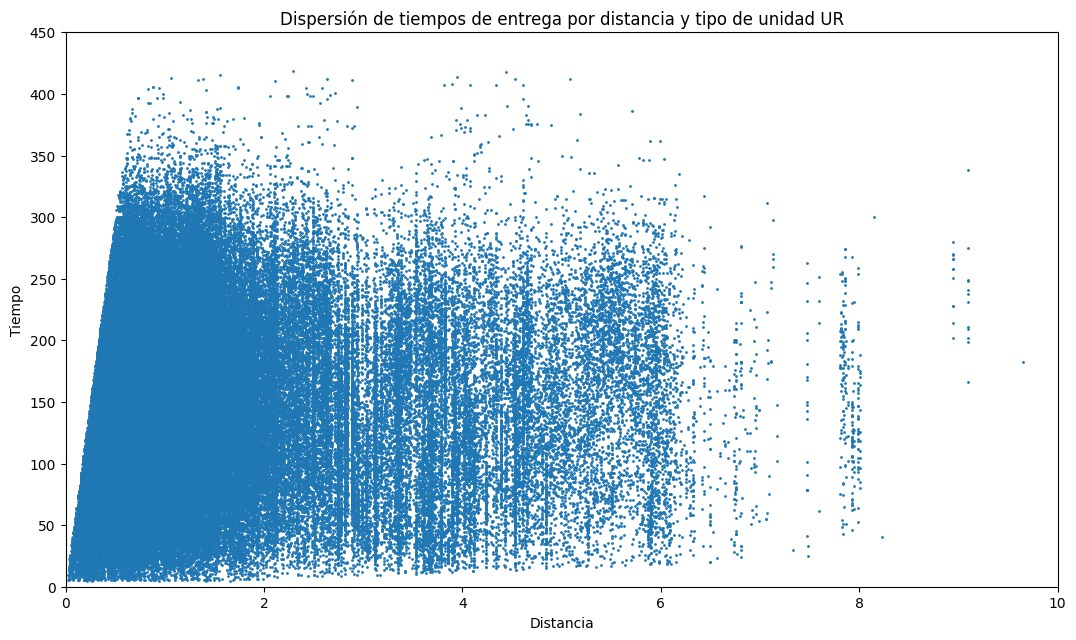

In [92]:
# Dispersión de tiempos de entrega por distancia y tipo de unidad (UR)
tipo_unidad = "UR"
fig, ax = plt.subplots()
DPI = fig.get_dpi()
fig.set_size_inches(1280.0/float(DPI),720.0/float(DPI))
df_tipo = df_all.loc[df_all["tipo"] == tipo_unidad]
ax.scatter(df_tipo.distancia, df_tipo.tiempo_entrega, 1)
ax.set(xlim=(0, 10))
ax.set(ylim=(0, 450))
plt.title("Dispersión de tiempos de entrega por distancia y tipo de unidad " + tipo_unidad)
plt.xlabel("Distancia")
plt.ylabel("Tiempo")
plt.show()

In [93]:
# Dispersión de tiempos de entrega por distancia y tipo de unidad (UD)
tipo_unidad = "UD"
fig, ax = plt.subplots()
DPI = fig.get_dpi()
fig.set_size_inches(1280.0/float(DPI),720.0/float(DPI))
df_tipo = df_all.loc[df_all["tipo"] == tipo_unidad]
ax.scatter(df_tipo.distancia, df_tipo.tiempo_entrega, 1)
ax.set(xlim=(0, 32))
ax.set(ylim=(0, 450))
plt.title("Dispersión de tiempos de entrega por distancia y tipo de unidad " + tipo_unidad)
plt.xlabel("Distancia")
plt.ylabel("Tiempo")
plt.show()

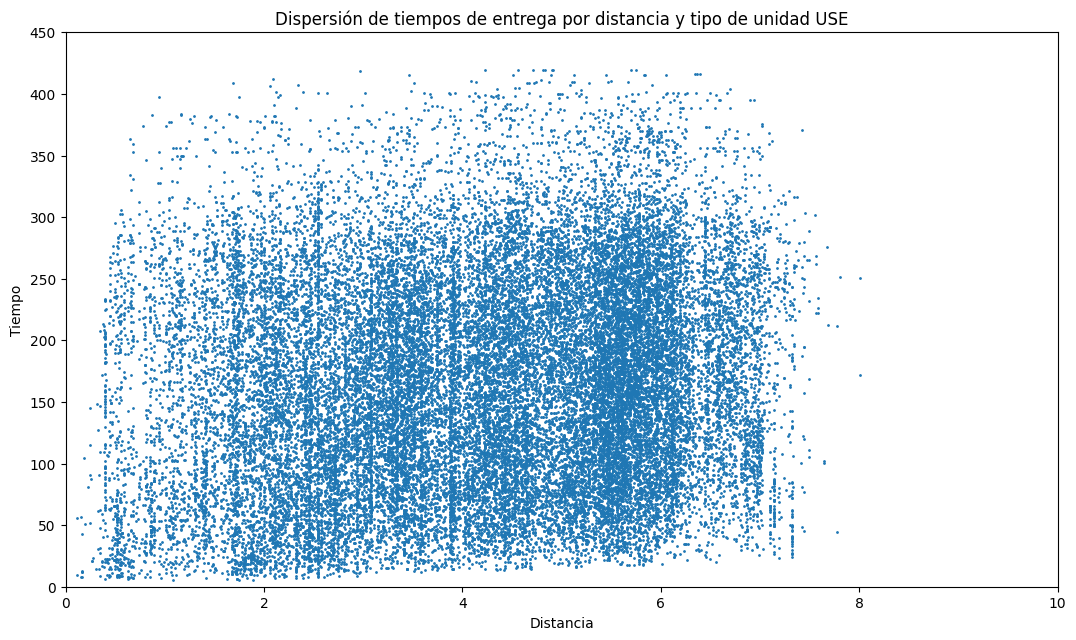

In [94]:
# Dispersión de tiempos de entrega por distancia y tipo de unidad (USE)
tipo_unidad = "USE"
fig, ax = plt.subplots()
DPI = fig.get_dpi()
fig.set_size_inches(1280.0/float(DPI),720.0/float(DPI))
df_tipo = df_all.loc[df_all["tipo"] == tipo_unidad]
ax.scatter(df_tipo.distancia, df_tipo.tiempo_entrega, 1)
ax.set(xlim=(0, 10))
ax.set(ylim=(0, 450))
plt.title("Dispersión de tiempos de entrega por distancia y tipo de unidad " + tipo_unidad)
plt.xlabel("Distancia")
plt.ylabel("Tiempo")
plt.show()

In [95]:
# Dispersión de tiempos de entrega por distancia y tipo de unidad (OT)
tipo_unidad = "OT"
fig, ax = plt.subplots()
DPI = fig.get_dpi()
fig.set_size_inches(1280.0/float(DPI),720.0/float(DPI))
df_tipo = df_all.loc[df_all["tipo"] == tipo_unidad]
ax.scatter(df_tipo.distancia, df_tipo.tiempo_entrega, 1)
ax.set(xlim=(0, 32))
ax.set(ylim=(0, 450))
plt.title("Dispersión de tiempos de entrega por distancia y tipo de unidad " + tipo_unidad)
plt.xlabel("Distancia")
plt.ylabel("Tiempo")
plt.show()

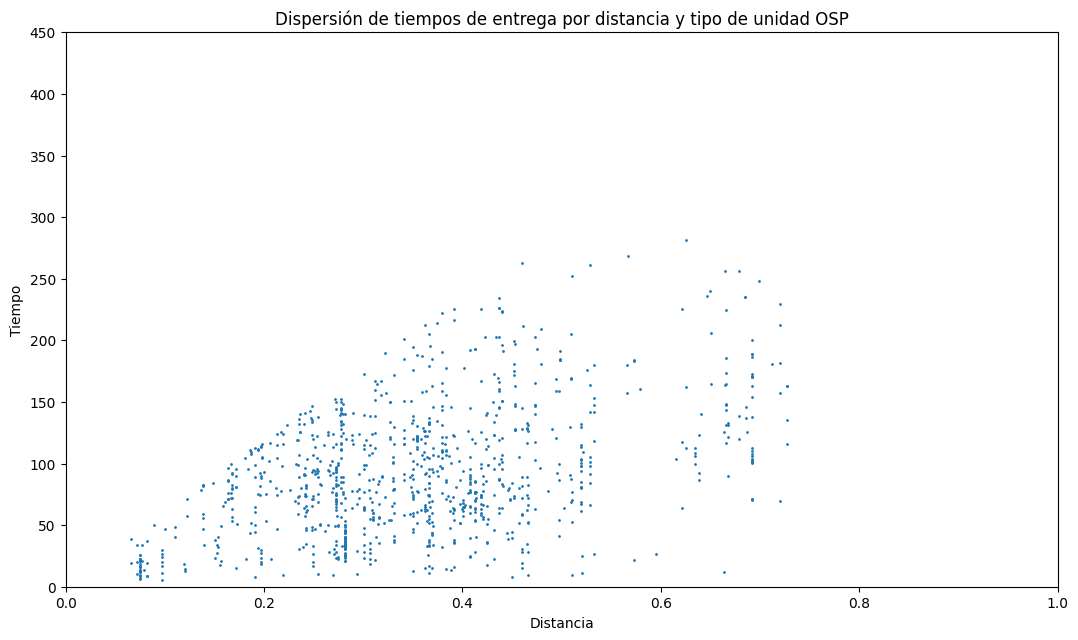

In [96]:
# Dispersión de tiempos de entrega por distancia y tipo de unidad (OSP)
tipo_unidad = "OSP"
fig, ax = plt.subplots()
DPI = fig.get_dpi()
fig.set_size_inches(1280.0/float(DPI),720.0/float(DPI))
df_tipo = df_all.loc[df_all["tipo"] == tipo_unidad]
ax.scatter(df_tipo.distancia, df_tipo.tiempo_entrega, 1)
ax.set(xlim=(0, 1))
ax.set(ylim=(0, 450))
plt.title("Dispersión de tiempos de entrega por distancia y tipo de unidad " + tipo_unidad)
plt.xlabel("Distancia")
plt.ylabel("Tiempo")
plt.show()

In [97]:
# Elimina las columna de codPaq y tipo
df_all = df_all.drop(columns=['codPaq', 'tipo', 'turno'])
df_all

mes_alta  diasem_alta  num_envios  alto  ancho  largo  peso  ...  osp  distancia  tiempo_entrega    x_dest     y_dest  min_reparto  dist_reparto
0              5            5           4    20     20     20   426  ...    0      0.508            43.2 -5.412126  37.331699          586         0.775
1             12            1          21     0      0      0   104  ...    0      4.767           150.7 -5.916385  37.405236          987        15.529
2             10            4          32    13     26     20   630  ...    0      0.827           169.2 -5.925359  37.409358          507        21.005
3              4            1           5    15     15     15    20  ...    0      7.603           238.2 -5.981454  37.517511          555        24.492
4              5            5           2     0      0      0  2000  ...    0      0.690            91.2 -5.983559  37.481530          551         1.180
...          ...          ...         ...   ...    ...    ...   ...  ...  ...        ...             ...       ...        ...          ...           ...
460806         3            1           2     2     25     30   195  ...    0      0.642           128.9 -5.449643  37.126202          541         0.642
460807        10            4           4    11     25     16  2200  ...    0      0.139            67.7 -5.992456  37.384440          542         0.139
460808         3            5          36    10     35     48   750  ...    0      1.136            90.6 -5.940943  37.376998          559        11.171
460809         1            2           9    24     34      2  1000  ...    0      0.838           158.7 -5.974201  37.378073          618         3.426
460810        12            5          22    25     25      1   357  ...    0      0.946           230.2 -5.972374  37.389700          551        13.449

[460811 rows x 21 columns]

In [98]:
# Elegir quedarse con medidas o peso volumétrico
list = ['alto', 'largo', 'ancho']
#list = ['pv']
df_all = df_all.drop(columns=list)
df_all

mes_alta  diasem_alta  num_envios  peso        pv     cp   unidad  ...  osp  distancia  tiempo_entrega    x_dest     y_dest  min_reparto  dist_reparto
0              5            5           4   426  1.333333  41620  4118794  ...    0      0.508            43.2 -5.412126  37.331699          586         0.775
1             12            1          21   104  0.000000  41020  4107896  ...    0      4.767           150.7 -5.916385  37.405236          987        15.529
2             10            4          32   630  1.126667  41019  4119494  ...    0      0.827           169.2 -5.925359  37.409358          507        21.005
3              4            1           5    20  0.562500  41200  4132294  ...    0      7.603           238.2 -5.981454  37.517511          555        24.492
4              5            5           2  2000  0.000000  41309  4130907  ...    0      0.690            91.2 -5.983559  37.481530          551         1.180
...          ...          ...         ...   ...       ...    ...      ...  ...  ...        ...             ...       ...        ...          ...           ...
460806         3            1           2   195  0.250000  41530  4118894  ...    0      0.642           128.9 -5.449643  37.126202          541         0.642
460807        10            4           4  2200  0.733333  41004  4101696  ...    0      0.139            67.7 -5.992456  37.384440          542         0.139
460808         3            5          36   750  2.800000  41006  4107896  ...    0      1.136            90.6 -5.940943  37.376998          559        11.171
460809         1            2           9  1000  0.272000  41005  4108096  ...    0      0.838           158.7 -5.974201  37.378073          618         3.426
460810        12            5          22   357  0.104167  41007  4107996  ...    0      0.946           230.2 -5.972374  37.389700          551        13.449

[460811 rows x 18 columns]

In [99]:
# Calcula el mapa de correlaciones de variables (1 unidad)
corr = df_all.corr().round(2)
corr

mes_alta  diasem_alta  num_envios  peso    pv    cp  unidad  ...   osp  distancia  tiempo_entrega  x_dest  y_dest  min_reparto  dist_reparto
mes_alta            1.00         0.06        0.03  0.01 -0.00  0.03   -0.02  ... -0.00       0.04           -0.11   -0.01   -0.00         0.30          0.03
diasem_alta         0.06         1.00       -0.15  0.02  0.01 -0.00   -0.01  ... -0.00       0.01           -0.01   -0.00   -0.01         0.00         -0.03
num_envios          0.03        -0.15        1.00  0.02 -0.00 -0.17   -0.16  ... -0.02       0.02            0.04   -0.08   -0.00         0.09          0.46
peso                0.01         0.02        0.02  1.00  0.18 -0.02   -0.07  ... -0.01       0.10            0.01    0.00    0.00         0.07          0.07
pv                 -0.00         0.01       -0.00  0.18  1.00 -0.00   -0.02  ... -0.00       0.03            0.00    0.00   -0.00         0.02          0.02
cp                  0.03        -0.00       -0.17 -0.02 -0.00  1.00    0.59  ...  0.00      -0.08           -0.13    0.11   -0.26        -0.05         -0.11
unidad             -0.02        -0.01       -0.16 -0.07 -0.02  0.59    1.00  ...  0.03      -0.09           -0.13    0.14   -0.05        -0.11         -0.12
ur                 -0.02        -0.01        0.13 -0.17 -0.05 -0.70   -0.39  ... -0.03      -0.10            0.09   -0.22    0.12        -0.07         -0.02
ud                  0.05         0.00       -0.07  0.00  0.00  0.59   -0.09  ... -0.04       0.03           -0.03    0.12   -0.23        -0.01         -0.00
use                -0.02         0.03        0.10  0.33  0.09 -0.29   -0.30  ... -0.01       0.24            0.10   -0.09    0.05         0.25          0.20
ot                 -0.03        -0.01       -0.15 -0.03 -0.01  0.30    0.78  ... -0.02      -0.08           -0.13    0.19    0.08        -0.08         -0.11
osp                -0.00        -0.00       -0.02 -0.01 -0.00  0.00    0.03  ...  1.00      -0.02           -0.03    0.01    0.25        -0.01         -0.02
distancia           0.04         0.01        0.02  0.10  0.03 -0.08   -0.09  ... -0.02       1.00            0.12    0.08    0.10         0.12          0.40
tiempo_entrega     -0.11        -0.01        0.04  0.01  0.00 -0.13   -0.13  ... -0.03       0.12            1.00   -0.03    0.03        -0.11          0.26
x_dest             -0.01        -0.00       -0.08  0.00  0.00  0.11    0.14  ...  0.01       0.08           -0.03    1.00   -0.03         0.00         -0.01
y_dest             -0.00        -0.01       -0.00  0.00 -0.00 -0.26   -0.05  ...  0.25       0.10            0.03   -0.03    1.00        -0.02          0.04
min_reparto         0.30         0.00        0.09  0.07  0.02 -0.05   -0.11  ... -0.01       0.12           -0.11    0.00   -0.02         1.00          0.10
dist_reparto        0.03        -0.03        0.46  0.07  0.02 -0.11   -0.12  ... -0.02       0.40            0.26   -0.01    0.04         0.10          1.00

[18 rows x 18 columns]

In [100]:
# Muestra la matriz de correlación (1 unidad)
fig, ax = plt.subplots()
DPI = fig.get_dpi()
fig.set_size_inches(1280.0/float(DPI),720.0/float(DPI))

sns.heatmap(data=corr, cmap='coolwarm', annot=True, fmt=".1f", annot_kws={"size": 8}, linewidth=.5)
plt.show()

### 1.2.2 Dispersión de tiempos de entrega por distancia y PV

In [199]:
# Recorre el dataframe añadiendo el rango del PV
df_all = df_all.reset_index(drop=True)
for k in range(len(df_all)):
    pv = df_all.at[k,'pv']
    pv_rango = 0
    if pv == 0:
        pv_rango = 0
    elif pv <= 1:
        pv_rango = 1
    elif pv <= 10:
        pv_rango = 10
    elif pv <= 20:
        pv_rango = 20
    else:
        pv_rango = 100
    df_all.at[k, 'pv_rango'] = pv_rango

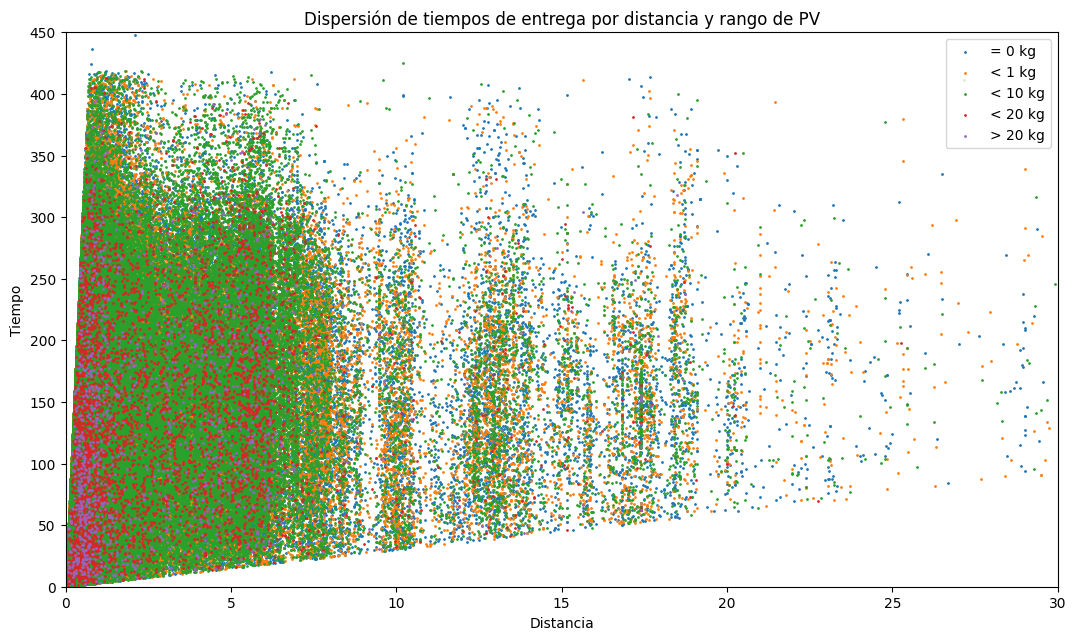

In [204]:
# Dispersión de tiempos de entrega por distancia y rango de PV
pv = ['= 0 kg', '< 1 kg', '< 10 kg', '< 20 kg', '> 20 kg']
pv_rango = [0, 1, 10, 20, 100]

fig, ax = plt.subplots()
DPI = fig.get_dpi()
fig.set_size_inches(1280.0/float(DPI),720.0/float(DPI))
for k in range(len(pv)):
    df_pv = df_all.loc[df_all["pv_rango"] == pv_rango[k]]
    ax.scatter(df_pv.distancia, df_pv.tiempo_entrega, 1, label=pv[k])
ax.legend(loc='upper right')
ax.set(xlim=(0, 30))
ax.set(ylim=(0, 450))
plt.title("Dispersión de tiempos de entrega por distancia y rango de PV")
plt.xlabel("Distancia")
plt.ylabel("Tiempo")
plt.show()

### 2. Preparación del dataset para el entrenamiento

### 2.1 Dataframe con 1 unidad

In [67]:
# Selecciona una unidad
#df1 = df.loc[df["unidad"] == 4130494]
df1 = df.loc[df["unidad"] == 4101796]
print(df1.count())
df1.head()


codPaq            37661
mes_alta          37661
diasem_alta       37661
turno             37661
num_envios        37661
alto              37661
ancho             37661
largo             37661
peso              37661
pv                37661
cp                37661
unidad            37661
tipo              37661
ur                37661
ud                37661
use               37661
ot                37661
osp               37661
distancia         37661
tiempo_entrega    37661
x_dest            37661
y_dest            37661
min_reparto       37661
dist_reparto      37661
dtype: int64


codPaq  mes_alta  diasem_alta  turno  num_envios  alto  ancho  ...  osp  distancia  tiempo_entrega    x_dest     y_dest min_reparto  dist_reparto
23  PQ8BRK0734983620141008E        12            4      1          10    28     38  ...    0      4.750           151.5 -5.974810  37.406479         980         7.274
36  PQ9DXH0710011350141013T        11            3      1           3    10     21  ...    0      4.017            64.8 -5.979335  37.372615        1004         4.017
48  PQ56GB0763646930141008N         3            3      0          11     2     52  ...    0      4.813            73.6 -5.979162  37.402982         499         5.017
56  PQ7MJG1103744740141008D         1            3      1          12    40     22  ...    0      4.555            92.7 -5.972933  37.405519         998         6.301
59  PQ829K0200064330241020K        11            1      1          26    27     22  ...    0      3.449           171.4 -5.941825  37.408725         962        40.206

[5 rows x 24 columns]

In [59]:
df.columns

Index(['codPaq', 'mes_alta', 'diasem_alta', 'turno', 'num_envios', 'alto', 'ancho', 'largo', 'peso', 'pv', 'cp', 'unidad', 'tipo', 'ur', 'ud', 'use', 'ot', 'osp', 'distancia', 'tiempo_entrega', 'x_dest', 'y_dest', 'min_reparto', 'dist_reparto'], dtype='object')

In [68]:
# Elimina las columnas relacionadas o irrelevantes (1 unidad)
list = ['codPaq', 'turno', 'tipo', 'unidad', 'cp', 'tipo', 'ur', 'ud', 'use', 'ot', 'osp']
df1 = df1.drop(columns=list)
df1

mes_alta  diasem_alta  num_envios  alto  ancho  largo   peso         pv  distancia  tiempo_entrega    x_dest     y_dest  min_reparto  dist_reparto
23            12            4          10    28     38     14   2000   2.482667      4.750           151.5 -5.974810  37.406479          980         7.274
36            11            3           3    10     21     27   1000   0.945000      4.017            64.8 -5.979335  37.372615         1004         4.017
48             3            3          11     2     52     37   3700   0.641333      4.813            73.6 -5.979162  37.402982          499         5.017
56             1            3          12    40     22     11   1700   1.613333      4.555            92.7 -5.972933  37.405519          998         6.301
59            11            1          26    27     22     31  12850   3.069000      3.449           171.4 -5.941825  37.408725          962        40.206
...          ...          ...         ...   ...    ...    ...    ...        ...        ...             ...       ...        ...          ...           ...
460745         9            3           3     0      0      0   2566   0.000000      5.972           155.5 -6.001994  37.379699          531         5.972
460763         2            1           6    89     50     22   5820  16.316667      5.020           296.9 -5.983206  37.401445          521        10.079
460773         5            5           3    17     43     50   2380   6.091667      6.653           303.2 -6.009723  37.378962          937         7.199
460778         8            4           6     9     70     70   5075   7.350000      4.400           152.5 -5.984219  37.379219          975         4.400
460797        12            3           5    12     35     62   2013   4.340000      5.997           104.6 -6.002057  37.373649          566         5.997

[37661 rows x 14 columns]

In [69]:
# Elegir quedarse con medidas o peso volumétrico
list = ['alto', 'largo', 'ancho']
#list = ["pv"]
df1 = df1.drop(columns=list)
df1

mes_alta  diasem_alta  num_envios   peso         pv  distancia  tiempo_entrega    x_dest     y_dest  min_reparto  dist_reparto
23            12            4          10   2000   2.482667      4.750           151.5 -5.974810  37.406479          980         7.274
36            11            3           3   1000   0.945000      4.017            64.8 -5.979335  37.372615         1004         4.017
48             3            3          11   3700   0.641333      4.813            73.6 -5.979162  37.402982          499         5.017
56             1            3          12   1700   1.613333      4.555            92.7 -5.972933  37.405519          998         6.301
59            11            1          26  12850   3.069000      3.449           171.4 -5.941825  37.408725          962        40.206
...          ...          ...         ...    ...        ...        ...             ...       ...        ...          ...           ...
460745         9            3           3   2566   0.000000      5.972           155.5 -6.001994  37.379699          531         5.972
460763         2            1           6   5820  16.316667      5.020           296.9 -5.983206  37.401445          521        10.079
460773         5            5           3   2380   6.091667      6.653           303.2 -6.009723  37.378962          937         7.199
460778         8            4           6   5075   7.350000      4.400           152.5 -5.984219  37.379219          975         4.400
460797        12            3           5   2013   4.340000      5.997           104.6 -6.002057  37.373649          566         5.997

[37661 rows x 11 columns]

In [70]:
# Convierte la columna de diasem_alta a one-hot-encodding y la elimina
encoder = OneHotEncoder(sparse_output=False)
column_days = ['L', 'M', 'X', 'J', 'V', 'S']
one_hot_encoder = pd.get_dummies(df1['diasem_alta'], dtype=int)
one_hot_encoder.columns=column_days
df1 = pd.concat([df1, one_hot_encoder], axis=1).drop(columns=['diasem_alta'])


In [63]:
df1

mes_alta  num_envios   peso         pv     cp  distancia  tiempo_entrega  ...  dist_reparto  L  M  X  J  V  S
65             3          22   1850   1.613333  41008      4.416            80.2  ...         4.688  0  1  0  0  0  0
104            1           8   1080   1.904000  41016      1.954           120.8  ...         1.956  0  0  1  0  0  0
111            3          13    480   0.363000  41003      5.074           194.0  ...         6.017  0  0  0  0  1  0
116           11          16   2700   5.088000  41008      4.604            69.2  ...         4.604  1  0  0  0  0  0
134            5           4  14790  23.600000  41001      6.066           209.1  ...         6.317  1  0  0  0  0  0
...          ...         ...    ...        ...    ...        ...             ...  ...           ... .. .. .. .. .. ..
461379         4           7    861   0.750000  41007      3.584           203.9  ...         5.679  1  0  0  0  0  0
461391        11           5   1856   1.525333  41009      5.426           189.8  ...         6.884  1  0  0  0  0  0
461404        12           4   1565   1.824667  41019      3.807           117.8  ...         4.089  1  0  0  0  0  0
461421         4          14   2165   7.410000  41007      3.161           222.2  ...        24.443  0  0  0  1  0  0
461430        11           3    844   4.500000  41005      3.262           176.7  ...         4.030  0  0  0  1  0  0

[37631 rows x 17 columns]

In [64]:
df1.describe()

mes_alta    num_envios          peso            pv            cp     distancia  tiempo_entrega  ...  dist_reparto             L             M             X             J             V             S
count  37631.000000  37631.000000  37631.000000  37631.000000  37631.000000  37631.000000    37631.000000  ...  37631.000000  37631.000000  37631.000000  37631.000000  37631.000000  37631.000000  37631.000000
mean       6.604794     10.743244   3586.680396      3.984103  41010.429247      4.223589      163.694451  ...     10.723108      0.214717      0.189976      0.213441      0.189020      0.185512      0.007334
std        3.876257      7.166534   4203.075599     25.724733      8.296549      1.631748       85.810749  ...     12.914859      0.410631      0.392287      0.409742      0.391529      0.388717      0.085327
min        1.000000      1.000000      0.000000      0.000000  41000.000000      0.119000        0.900000  ...      0.119000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000
25%        3.000000      6.000000   1050.000000      1.155000  41006.000000      2.991000       95.000000  ...      4.723000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000
50%        6.000000      9.000000   1900.000000      2.541000  41009.000000      4.420000      159.400000  ...      6.590000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000
75%       11.000000     14.000000   4200.000000      4.666667  41014.000000      5.588000      226.200000  ...     10.362500      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000
max       12.000000     50.000000  40000.000000   4900.000000  41106.000000      8.008000     2065.500000  ...    163.311000      1.000000      1.000000      1.000000      1.000000      1.000000      1.000000

[8 rows x 17 columns]

In [65]:
df1.columns

Index(['mes_alta', 'num_envios', 'peso', 'pv', 'cp', 'distancia', 'tiempo_entrega', 'x_dest', 'y_dest', 'min_reparto', 'dist_reparto', 'L', 'M', 'X', 'J', 'V', 'S'], dtype='object')

In [66]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37631 entries, 65 to 461430
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mes_alta        37631 non-null  int64  
 1   num_envios      37631 non-null  int64  
 2   peso            37631 non-null  int64  
 3   pv              37631 non-null  float64
 4   cp              37631 non-null  int64  
 5   distancia       37631 non-null  float64
 6   tiempo_entrega  37631 non-null  float64
 7   x_dest          37631 non-null  float64
 8   y_dest          37631 non-null  float64
 9   min_reparto     37631 non-null  int64  
 10  dist_reparto    37631 non-null  float64
 11  L               37631 non-null  int32  
 12  M               37631 non-null  int32  
 13  X               37631 non-null  int32  
 14  J               37631 non-null  int32  
 15  V               37631 non-null  int32  
 16  S               37631 non-null  int32  
dtypes: float64(6), int32(6), int64(5)


In [71]:
# Separa variables independientes y variable objetivo (1 unidad)
y = df1["tiempo_entrega"]
X = df1.drop("tiempo_entrega", axis=1)

### 2.2 Dataframe con todas las unidades

In [79]:
# Elimina las columnas relacionadas o irrelevantes (todas las unidades)
df_all = df
list = ['codPaq', 'turno', 'tipo', 'cp', 'alto', 'largo', 'ancho']
df_all = df_all.drop(columns=list)
df_all

mes_alta  diasem_alta  num_envios   peso        pv   unidad  ur  ...  osp  distancia  tiempo_entrega    x_dest     y_dest  min_reparto  dist_reparto
0             12            5          13    364  0.780000  4118094   0  ...    0      0.308            33.7 -5.926200  37.288664          592         0.344
1             12            3           3    125  0.561000  4128094   0  ...    0      0.199            75.7 -5.531480  37.656390          515         1.433
2              5            1           5    500  0.000000  4151003   0  ...    0      0.648           177.5 -5.747525  37.370274          596         3.986
3              6            4           1    999  0.363000  4151003   0  ...    0      0.362           149.8 -5.749255  37.373009          543         0.362
4             12            1          14    970  1.307167  4117994   0  ...    0      8.632           277.5 -5.753530  37.371262          962        44.283
...          ...          ...         ...    ...       ...      ...  ..  ...  ...        ...             ...       ...        ...          ...           ...
460806         1            5           1    215  0.182000  4192802   0  ...    0      0.923           158.5 -6.070350  37.321591          576         0.923
460807        11            3          11   2410  1.653000  4107996   1  ...    0      0.792           273.3 -5.972313  37.391548          535         1.696
460808        11            5           4    220  0.000000  4196001   0  ...    0      0.414            44.3 -6.077318  37.384279          730         1.085
460809         1            1          11  10350  1.932333  4117994   0  ...    0      0.614            56.6 -5.835575  37.336021          547         0.614
460810        12            1           4    380  0.000000  4107896   1  ...    0      4.390           116.1 -5.905196  37.384047          945         4.877

[460811 rows x 17 columns]

In [80]:
# Convierte la columna de diasem_alta a one-hot-encodding y la elimina
encoder = OneHotEncoder(sparse_output=False)
column_days = ['L', 'M', 'X', 'J', 'V', 'S']
one_hot_encoder = pd.get_dummies(df_all['diasem_alta'], dtype=int)
one_hot_encoder.columns=column_days
df_all = pd.concat([df_all, one_hot_encoder], axis=1).drop(columns=['diasem_alta'])


In [81]:
df_all

mes_alta  num_envios   peso        pv   unidad  ur  ud  ...  dist_reparto  L  M  X  J  V  S
0             12          13    364  0.780000  4118094   0   1  ...         0.344  0  0  0  0  1  0
1             12           3    125  0.561000  4128094   0   1  ...         1.433  0  0  1  0  0  0
2              5           5    500  0.000000  4151003   0   0  ...         3.986  1  0  0  0  0  0
3              6           1    999  0.363000  4151003   0   0  ...         0.362  0  0  0  1  0  0
4             12          14    970  1.307167  4117994   0   1  ...        44.283  1  0  0  0  0  0
...          ...         ...    ...       ...      ...  ..  ..  ...           ... .. .. .. .. .. ..
460806         1           1    215  0.182000  4192802   0   0  ...         0.923  0  0  0  0  1  0
460807        11          11   2410  1.653000  4107996   1   0  ...         1.696  0  0  1  0  0  0
460808        11           4    220  0.000000  4196001   0   0  ...         1.085  0  0  0  0  1  0
460809         1          11  10350  1.932333  4117994   0   1  ...         0.614  1  0  0  0  0  0
460810        12           4    380  0.000000  4107896   1   0  ...         4.877  1  0  0  0  0  0

[460811 rows x 22 columns]

In [7]:
df_all.describe().map(round, ndigits=2).iloc[:,:7]

mes_alta  num_envios       peso         pv      unidad         ur         ud
count  460811.00   460811.00  460811.00  460811.00   460811.00  460811.00  460811.00
mean        6.82        8.07    1101.85       1.14  4123436.42       0.34       0.39
std         4.02        7.68    2219.17       9.23    21252.09       0.47       0.49
min         1.00        1.00       0.00       0.00  4101696.00       0.00       0.00
25%         3.00        3.00     200.00       0.00  4108096.00       0.00       0.00
50%         6.00        6.00     500.00       0.25  4118794.00       0.00       0.00
75%        11.00       10.00    1000.00       1.12  4124994.00       1.00       1.00
max        12.00       92.00   40000.00    4900.00  4198001.00       1.00       1.00

In [8]:
df_all.describe().map(round, ndigits=2).iloc[:,7:14]

use         ot        osp  distancia  tiempo_entrega     x_dest     y_dest
count  460811.00  460811.00  460811.00  460811.00       460811.00  460811.00  460811.00
mean        0.08       0.19       0.00       1.97          138.66      -5.89      37.37
std         0.27       0.39       0.05       2.84           78.71       0.27       0.14
min         0.00       0.00       0.00       0.01            5.00      -6.51      36.85
25%         0.00       0.00       0.00       0.61           74.80      -6.00      37.33
50%         0.00       0.00       0.00       1.02          131.90      -5.97      37.38
75%         0.00       0.00       0.00       1.97          195.10      -5.91      37.40
max         1.00       1.00       1.00      98.03          420.00      -4.67      38.10

In [9]:
df_all.describe().map(round, ndigits=2).iloc[:,14:]

min_reparto  dist_reparto          L          M         X          J          V          S
count    460811.00     460811.00  460811.00  460811.00  460811.0  460811.00  460811.00  460811.00
mean        605.77          4.89       0.27       0.18       0.2       0.17       0.18       0.00
std         135.29          8.71       0.44       0.38       0.4       0.38       0.38       0.07
min         399.00          0.01       0.00       0.00       0.0       0.00       0.00       0.00
25%         529.00          0.99       0.00       0.00       0.0       0.00       0.00       0.00
50%         559.00          2.04       0.00       0.00       0.0       0.00       0.00       0.00
75%         601.00          5.27       1.00       0.00       0.0       0.00       0.00       0.00
max        1319.00        295.28       1.00       1.00       1.0       1.00       1.00       1.00

In [82]:
# Separa variables independientes y variable objetivo (todas las unidades)
y = df_all["tiempo_entrega"]
X = df_all.drop("tiempo_entrega", axis=1)

### 2.3 Conjuntos de entrenamiento y test

In [83]:
# Separa conjuntos de datos de entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)
X_train.describe()

mes_alta     num_envios           peso             pv        unidad             ur             ud  ...   dist_reparto              L              M              X              J              V              S
count  322567.000000  322567.000000  322567.000000  322567.000000  3.225670e+05  322567.000000  322567.000000  ...  322567.000000  322567.000000  322567.000000  322567.000000  322567.000000  322567.000000  322567.000000
mean        6.818013       8.070423    1103.864679       1.143305  4.123376e+06       0.336888       0.387228  ...       4.898865       0.267002       0.179981       0.195978       0.173815       0.178989       0.004235
std         4.015767       7.692721    2223.377899      10.316498  2.121549e+04       0.472647       0.487117  ...       8.708077       0.442394       0.384172       0.396952       0.378951       0.383344       0.064937
min         1.000000       1.000000       0.000000       0.000000  4.101696e+06       0.000000       0.000000  ...       0.012000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000
25%         3.000000       3.000000     200.000000       0.000000  4.108096e+06       0.000000       0.000000  ...       0.986000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000
50%         6.000000       6.000000     500.000000       0.250000  4.118794e+06       0.000000       0.000000  ...       2.039000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000
75%        11.000000      10.000000    1000.000000       1.116000  4.124894e+06       1.000000       1.000000  ...       5.280000       1.000000       0.000000       0.000000       0.000000       0.000000       0.000000
max        12.000000      92.000000   40000.000000    4900.000000  4.198001e+06       1.000000       1.000000  ...     295.275000       1.000000       1.000000       1.000000       1.000000       1.000000       1.000000

[8 rows x 21 columns]

In [14]:
y_train.describe()

count    322567.000000
mean        138.559355
std          78.778610
min           5.000000
25%          74.600000
50%         131.800000
75%         195.100000
max         419.900000
Name: tiempo_entrega, dtype: float64

### 3. Redes Neuronales

In [30]:
# Selecciona todas las unidades y elimina las columnas relacionadas o irrelevantes
df_all = df.copy()
list = ['codPaq', 'turno', 'tipo', 'cp', 'alto', 'largo', 'ancho']
df_all = df_all.drop(columns=list)

In [31]:
# Convierte la columna de diasem_alta a one-hot-encodding y la elimina
encoder = OneHotEncoder(sparse_output=False)
column_days = ['L', 'M', 'X', 'J', 'V', 'S']
one_hot_encoder = pd.get_dummies(df_all['diasem_alta'], dtype=int)
one_hot_encoder.columns=column_days
df_all = pd.concat([df_all, one_hot_encoder], axis=1).drop(columns=['diasem_alta'])

In [32]:
# Separa variables independientes y variable objetivo (todas las unidades)
y = df_all["tiempo_entrega"]
X = df_all.drop("tiempo_entrega", axis=1)

In [33]:
# Separa conjuntos de datos de entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)
X_train.describe()

mes_alta     num_envios           peso             pv        unidad             ur             ud  ...   dist_reparto              L              M              X              J              V              S
count  322567.000000  322567.000000  322567.000000  322567.000000  3.225670e+05  322567.000000  322567.000000  ...  322567.000000  322567.000000  322567.000000  322567.000000  322567.000000  322567.000000  322567.000000
mean        6.827422       8.042221    1102.390976       1.140227  4.123430e+06       0.335533       0.387857  ...       4.892191       0.265551       0.180632       0.196548       0.173620       0.179253       0.004396
std         4.016198       7.653303    2214.848694      10.311469  2.123395e+04       0.472177       0.487263  ...       8.715604       0.441627       0.384714       0.397388       0.378783       0.383564       0.066156
min         1.000000       1.000000       0.000000       0.000000  4.101696e+06       0.000000       0.000000  ...       0.012000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000
25%         3.000000       3.000000     200.000000       0.000000  4.108096e+06       0.000000       0.000000  ...       0.986000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000
50%         6.000000       6.000000     500.000000       0.250000  4.118794e+06       0.000000       0.000000  ...       2.036000       0.000000       0.000000       0.000000       0.000000       0.000000       0.000000
75%        11.000000      10.000000    1000.000000       1.120000  4.124894e+06       1.000000       1.000000  ...       5.266000       1.000000       0.000000       0.000000       0.000000       0.000000       0.000000
max        12.000000      92.000000   40000.000000    4900.000000  4.198001e+06       1.000000       1.000000  ...     294.676000       1.000000       1.000000       1.000000       1.000000       1.000000       1.000000

[8 rows x 21 columns]

In [34]:
# Escala las variables al rango (0,1)
scaler_model = MinMaxScaler()
scaler_model.fit(X_train)

X_train = pd.DataFrame(scaler_model.transform(X_train), columns=X_train.columns, index=X_train.index)

scaler_model.fit(X_test)

X_test = pd.DataFrame(scaler_model.transform(X_test), columns=X_test.columns, index=X_test.index)

### 3.1 Funciones

In [9]:
# Número de epochs para el entrenamiento
EPOCHS = 1000

# Definicion del método Early Stopping callback
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [10]:
# Función para mostrar las gráficas el entrenamiento
def plot_history(history, model_name):
	hist = pd.DataFrame(history.history)
	hist['epoch'] = history.epoch

	fig, axs = plt.subplots(1, 2)
	fig.set_size_inches(18,5)
	fig.suptitle('Entrenamiento (' + model_name + ')')

    # [0, 0]
	axs[0].set(xlabel='Epoch')
	axs[0].set(ylabel='Mean Abs Error (MAE)')
	axs[0].plot(hist['epoch'], hist['mae'], label='Train Error')
	axs[0].plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
	axs[0].set_ylim([0,150])
	axs[0].legend()

	# [0, 1]
	axs[1].set(xlabel='Epoch')
	axs[1].set(ylabel='Mean Square Error (MSE)')
	axs[1].plot(hist['epoch'], hist['mse'], label='Train Error')
	axs[1].plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
	axs[1].set_ylim([0,15000])
	axs[1].legend()
	plt.show()

In [11]:
# Función para mostrar resultados del conjunto de test
def resultados(mae, rmse, r2):
    print()
    print("MAE: {:5.2f} minutos".format(mae))
    print("RMSE: {:5.2f} minutos".format(rmse))
    print("R2: {:5.2f}".format(r2))

In [12]:
# Función para mostrar la gráfica de predicciones frente al valor real
def plot_predictions(y_test, y_pred, model_name):
    max_range = 120
    mid_range = 60
    min_range = 30
    max_value = 500

    fig, ax = plt.subplots()
    DPI = fig.get_dpi()
    fig.set_size_inches(1280.0/float(DPI),720.0/float(DPI))

    plt.scatter(y_test, y_pred, 1)
    plt.title("Tiempo de entrega (minutos) - " + model_name)
    plt.xlabel('Real')
    plt.ylabel('Predicción')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0, max_value])
    plt.ylim([0, max_value])
    plt.plot([0, max_value], [min_range, max_value + min_range], color='green', label='+-30m')
    plt.plot([min_range, max_value + min_range], [0, max_value], color='green')
    plt.plot([0, max_value], [mid_range, max_value + mid_range], color='orange', label='+-1h')
    plt.plot([mid_range, max_value + mid_range], [0, max_value], color='orange')
    plt.plot([0, max_value], [max_range, max_value + max_range], color='red', label='+-2h')
    plt.plot([max_range, max_value + max_range], [0, max_value], color='red')
    plt.legend()
    plt.show()

In [13]:
# Función para mostrar el porcentaje de precisión con rangos de 15, 30 y 60 minutos
def accuracy(error):
    print("Precisión:")
    print("+-15m: " + str(round(round(error.loc[(error > -15) & (error < 15)].count() / error.count(),3) * 100,1)) + "%")
    print("+-30m: " + str(round(round(error.loc[(error > -30) & (error < 30)].count() / error.count(),3) * 100,1)) + "%")
    print("+-1h : " + str(round(round(error.loc[(error > -60) & (error < 60)].count() / error.count(),3) * 100,1)) + "%")
    print("+-2h : " + str(round(round(error.loc[(error > -120) & (error < 120)].count() / error.count(),3) * 100,1)) + "%")

### 3.2 Red Neuronal (FNN)

### 3.2.1 Optimización de parámetros (FNN)

In [115]:
# Búsqueda de parámetros óptimos (FNN)
def objective(trial):

    units1 = trial.suggest_int('units1', 16, 128, step=8)
    units2 = trial.suggest_int('units2', 16, 128, step=8)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.003, step=0.001)
    dropout_rate = trial.suggest_float('dropout_rate', 0.25, 0.75, step=0.05)
    
    model = keras.Sequential(name='FNN')
    model.add(keras.Input(shape=(len(X_train.keys()),)))
    model.add(keras.layers.Dense(units=units1, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(units=units2, activation='relu'))
    model.add(keras.layers.Dense(1, activation='relu'))
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[early_stop])
    y_pred = model.predict(X_test, verbose=0).flatten()
    
    return mean_absolute_error(y_test, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-06-24 12:54:40,454] A new study created in memory with name: no-name-5a9cbde5-56fc-4fa2-97de-7b6179c37ce2
[W 2024-06-24 12:54:44,844] Trial 0 failed with parameters: {'units1': 24, 'units2': 48, 'learning_rate': 0.001, 'dropout_rate': 0.25} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\C005145\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\C005145\AppData\Local\Temp\ipykernel_13304\3689174359.py", line 19, in objective
    model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[early_stop])
  File "c:\Users\C005145\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\C005145\AppData\Local\Programs\P

KeyboardInterrupt: 

In [145]:
# Resultados (FNN)
best_params = study.best_params
best_mae = study.best_value

print("Mejores hiperparámetros encontrados:", best_params)
print("MAE asociado a los mejores hiperparámetros:", best_mae)

Mejores hiperparámetros encontrados: {'units1': 48, 'units2': 40, 'learning_rate': 0.001, 'dropout_rate': 0.25}
MAE asociado a los mejores hiperparámetros: 46.92828695932537


### 3.2.2 Construccion del modelo (FNN)

In [15]:
# Definición de un modelo básico con una capa oculta (FNN)
def build_model_fnn():
    model = keras.Sequential([
	    keras.Input(shape=(len(X_train.keys()),)),
        layers.Dense(48, activation='relu', name='Dense_1'),
        layers.Dropout(0.25, name="Dropout"),
        layers.Dense(40, activation='relu', name='Dense_2'),
        layers.Dense(1, activation='relu', name='Output')
    ], name="FNN")

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse', 'root_mean_squared_error', 'r2_score'])

    return model

In [16]:
# Construcción del modelo (FNN)
model_fnn = build_model_fnn()
model_fnn.summary()

Model: "FNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense_1 (Dense)                 │ (None, 48)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 40)             │         1,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,057 (11.94 KB)

 Trainable params: 3,057 (11.94 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Entrenamiento del modelo (FNN)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history_fnn = model_fnn.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, verbose=2, callbacks=[early_stop])

Epoch 1/1000
8065/8065 - 9s - 1ms/step - loss: 6116.3916 - mae: 63.4997 - mse: 6116.3916 - r2_score: 0.0122 - root_mean_squared_error: 78.2074 - val_loss: 5414.8550 - val_mae: 60.3786 - val_mse: 5414.8550 - val_r2_score: 0.1290 - val_root_mean_squared_error: 73.5857
Epoch 2/1000
8065/8065 - 8s - 1ms/step - loss: 5481.8760 - mae: 60.1750 - mse: 5481.8760 - r2_score: 0.1146 - root_mean_squared_error: 74.0397 - val_loss: 5264.3350 - val_mae: 59.1816 - val_mse: 5264.3350 - val_r2_score: 0.1532 - val_root_mean_squared_error: 72.5557
Epoch 3/1000
8065/8065 - 8s - 987us/step - loss: 5294.2056 - mae: 58.9259 - mse: 5294.2056 - r2_score: 0.1450 - root_mean_squared_error: 72.7613 - val_loss: 5101.0791 - val_mae: 58.0564 - val_mse: 5101.0791 - val_r2_score: 0.1794 - val_root_mean_squared_error: 71.4218
Epoch 4/1000
8065/8065 - 8s - 1ms/step - loss: 5204.7866 - mae: 58.4701 - mse: 5204.7866 - r2_score: 0.1594 - root_mean_squared_error: 72.1442 - val_loss: 5025.6543 - val_mae: 57.6097 - val_mse: 50

In [18]:
# Comprobación con un lote de 10 ejemplos (FNN)
example_batch = X_train[:10]
example_result = model_fnn.predict(example_batch)
example_result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


array([[187.27563],
       [121.35449],
       [233.02348],
       [148.82037],
       [132.59149],
       [184.3846 ],
       [212.64186],
       [178.30376],
       [198.76695],
       [199.35371]], dtype=float32)

In [19]:
# Muestra el progreso del entrenamiento (FNN)
hist = pd.DataFrame(history_fnn.history)
hist['epoch'] = history_fnn.epoch
hist.tail()

loss        mae          mse  r2_score  root_mean_squared_error     val_loss    val_mae      val_mse  val_r2_score  val_root_mean_squared_error  epoch
46  3796.281982  48.236225  3796.281982  0.386876                61.613976  3659.667236  47.448006  3659.667236      0.411298                    60.495182     46
47  3792.641113  48.211758  3792.641113  0.387465                61.584423  3699.813232  48.303844  3699.813232      0.404840                    60.826092     47
48  3794.019775  48.192677  3794.019775  0.387246                61.595615  3692.636475  47.375080  3692.636475      0.405995                    60.767067     48
49  3784.562012  48.128136  3784.562012  0.388766                61.518795  3725.300781  48.632992  3725.300781      0.400740                    61.035244     49
50  3781.648193  48.124916  3781.648193  0.389230                61.495106  3814.117920  49.778961  3814.117920      0.386453                    61.758545     50

In [20]:
# Gráficas del entrenamiento (FNN)
plot_history(history_fnn, "FNN")

In [21]:
# Probamos con el conjunto de test (FNN)
loss, mae, mse, rmse, r2 = model_fnn.evaluate(X_test, y_test, verbose=2)
resultados(mae, rmse, r2)

4321/4321 - 3s - 678us/step - loss: 3799.8469 - mae: 49.6160 - mse: 3799.8469 - r2_score: 0.3865 - root_mean_squared_error: 61.6429

MAE: 49.62 minutos
RMSE: 61.64 minutos
R2:  0.39


In [22]:
# Comprobación con un lote de 20 ejemplos (FNN)
example_batch = X_test[:20]
example_result = model_fnn.predict(example_batch)
example_result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


array([[107.44592 ],
       [198.29526 ],
       [171.6372  ],
       [151.63585 ],
       [184.37625 ],
       [201.50192 ],
       [207.33682 ],
       [210.7577  ],
       [181.32877 ],
       [167.88846 ],
       [197.37512 ],
       [ 77.894455],
       [ 93.25816 ],
       [ 95.21739 ],
       [ 66.42305 ],
       [203.09735 ],
       [ 44.398254],
       [106.72058 ],
       [175.80171 ],
       [ 84.254776]], dtype=float32)

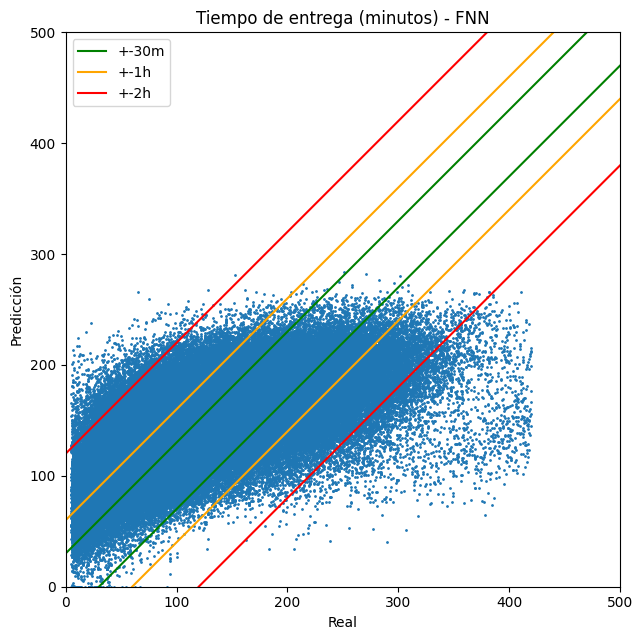

In [23]:
# Predicciones (FNN)
y_pred = model_fnn.predict(X_test, verbose=0)
plot_predictions(y_test, y_pred, 'FNN')

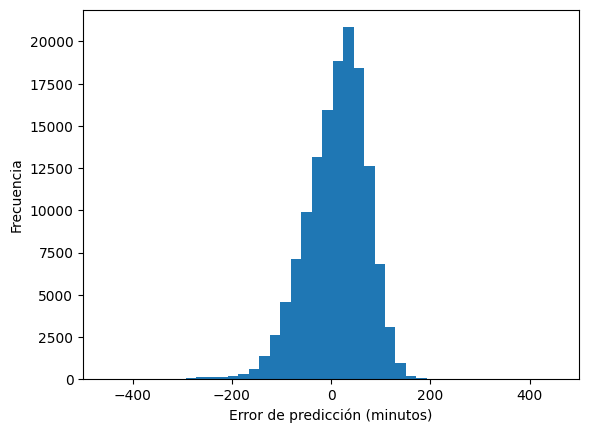

In [24]:
# Distribución de errores (FNN)
y_pred = np.array(y_pred).reshape(-1)
error = y_pred - y_test
plt.hist(error, bins = 25)
plt.xlim([-500, 500])
plt.xlabel("Error de predicción (minutos)")
_ = plt.ylabel("Frecuencia")

In [25]:
# Muestra porcentaje de acierto en rangos de +-15, +-30, +-1h y +-2h (FNN)
accuracy(error)

Precisión:
+-15m: 17.4%
+-30m: 34.9%
+-1h : 66.5%
+-2h : 95.9%


### 3.3 Red Neuronal Convolucional (CNN)

In [35]:
# Redimensionamiento de los datos de entrada (CNN)
train_size = X_train.shape[0]
train_steps = X_train.shape[1]

X_train = X_train.values.reshape(train_size, train_steps, 1)

eval_size = X_test.shape[0]
eval_steps = X_test.shape[1]

X_test = X_test.values.reshape(eval_size, eval_steps, 1)

### 3.3.1 Optimización de parámetros (CNN)

In [266]:
# Búsqueda de parámetros óptimos (CNN)
def objective(trial):

    filters = trial.suggest_int('filters', 16, 128, step=8)
    kernel_size = trial.suggest_int('kernel_size', 3, 7, step=2)
    units = trial.suggest_int('units', 16, 128, step=8)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.003, step=0.001)
    
    model = keras.Sequential(name='CNN')
    model.add(keras.Input(shape=(train_steps, 1)))
    model.add(keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=units, activation='relu'))
    model.add(keras.layers.Dense(units=units, activation='relu'))
    model.add(keras.layers.Dense(units=1, activation='relu'))
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[early_stop])
    y_pred = model.predict(X_test, verbose=0).flatten()
    
    return mean_absolute_error(y_test, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-06-23 20:10:58,908] A new study created in memory with name: no-name-b3106097-c6ee-4ec0-bb03-7c8bdc98a28a
[I 2024-06-23 20:21:01,174] Trial 0 finished with value: 54.613813362663535 and parameters: {'filters': 16, 'kernel_size': 5, 'units1': 56, 'units2': 64, 'learning_rate': 0.003, 'dropout_rate': 0.65}. Best is trial 0 with value: 54.613813362663535.
[I 2024-06-23 20:25:52,648] Trial 1 finished with value: 52.49860407841096 and parameters: {'filters': 32, 'kernel_size': 5, 'units1': 24, 'units2': 56, 'learning_rate': 0.001, 'dropout_rate': 0.25}. Best is trial 1 with value: 52.49860407841096.
[I 2024-06-23 20:32:48,841] Trial 2 finished with value: 51.47409509235136 and parameters: {'filters': 24, 'kernel_size': 7, 'units1': 16, 'units2': 24, 'learning_rate': 0.003, 'dropout_rate': 0.25}. Best is trial 2 with value: 51.47409509235136.
[I 2024-06-23 20:36:05,611] Trial 3 finished with value: 74.024722326957 and parameters: {'filters': 8, 'kernel_size': 7, 'units1': 16, 'units2

KeyboardInterrupt: 

In [267]:
# Resultados (CNN)
best_params = study.best_params
best_mae = study.best_value

print("Mejores hiperparámetros encontrados:", best_params)
print("MAE asociado a los mejores hiperparámetros:", best_mae)

Mejores hiperparámetros encontrados: {'filters': 24, 'kernel_size': 5, 'units1': 48, 'units2': 40, 'learning_rate': 0.002, 'dropout_rate': 0.3}
MAE asociado a los mejores hiperparámetros: 47.75923511143454


### 3.3.2 Construccion del modelo (CNN)

In [21]:
# Definición de un modelo convolucional (CNN)
def build_model_cnn():
    model = keras.Sequential([
        keras.Input(shape=(train_steps, 1)),
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name='Conv1D_1'),
        layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', name='Conv1D_2'),
        layers.MaxPooling1D(pool_size=2, name='MaxPooling1D', padding='same'),
        layers.Flatten(name='Flatten'),
        layers.Dense(64, activation='relu', name='Dense_1'),
        layers.Dense(64, activation='relu', name='Dense_2'),
        layers.Dense(1, activation='relu', name='Dense_3')
    ], name="CNN")

    optimizer = tf.keras.optimizers.RMSprop(0.002)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse', 'root_mean_squared_error', 'r2_score'])

    return model

In [22]:
# Construcción del modelo (CNN)
model_cnn = build_model_cnn()
model_cnn.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1D_1 (Conv1D)               │ (None, 21, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D_2 (Conv1D)               │ (None, 21, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling1D (MaxPooling1D)     │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 64)             │        90,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,361 (466.25 KB)

 Trainable params: 119,361 (466.25 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Comprobación con un lote de 20 ejemplos (CNN)
example_batch = X_train[:20]
example_result = model_cnn.predict(example_batch)
example_result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


array([[0.0668793 ],
       [0.06164246],
       [0.08142277],
       [0.02521474],
       [0.0220496 ],
       [0.07636182],
       [0.10001574],
       [0.06333981],
       [0.0567333 ],
       [0.07582536],
       [0.04163296],
       [0.0345576 ],
       [0.06232252],
       [0.02170282],
       [0.03731751],
       [0.06245782],
       [0.04370164],
       [0.0608292 ],
       [0.06315672],
       [0.0072321 ]], dtype=float32)

In [30]:
# Entrenamiento del modelo (CNN)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history_cnn = model_cnn.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, verbose=2, callbacks=[early_stop])

Epoch 1/1000
8065/8065 - 41s - 5ms/step - loss: 4934.1538 - mae: 56.2881 - mse: 4934.1538 - r2_score: 0.2039 - root_mean_squared_error: 70.2435 - val_loss: 5688.5679 - val_mae: 56.8210 - val_mse: 5688.5679 - val_r2_score: 0.0822 - val_root_mean_squared_error: 75.4226
Epoch 2/1000
8065/8065 - 41s - 5ms/step - loss: 4152.4419 - mae: 50.7734 - mse: 4152.4419 - r2_score: 0.3301 - root_mean_squared_error: 64.4394 - val_loss: 4149.2246 - val_mae: 49.2611 - val_mse: 4149.2246 - val_r2_score: 0.3306 - val_root_mean_squared_error: 64.4145
Epoch 3/1000
8065/8065 - 37s - 5ms/step - loss: 3889.5486 - mae: 48.8050 - mse: 3889.5486 - r2_score: 0.3725 - root_mean_squared_error: 62.3662 - val_loss: 4139.2769 - val_mae: 51.0187 - val_mse: 4139.2769 - val_r2_score: 0.3322 - val_root_mean_squared_error: 64.3372
Epoch 4/1000
8065/8065 - 48s - 6ms/step - loss: 3759.7251 - mae: 47.9060 - mse: 3759.7251 - r2_score: 0.3934 - root_mean_squared_error: 61.3166 - val_loss: 3841.3188 - val_mae: 48.4543 - val_mse: 

In [31]:
# Muestra el progreso del entrenamiento (CNN)
hist = pd.DataFrame(history_cnn.history)
hist['epoch'] = history_cnn.epoch
hist.tail()

loss        mae          mse  r2_score  root_mean_squared_error     val_loss    val_mae      val_mse  val_r2_score  val_root_mean_squared_error  epoch
20  3375.903564  45.102962  3375.903564  0.455361                58.102528  3437.544922  45.393871  3437.544922      0.445375                    58.630581     20
21  3375.600098  45.102177  3375.600098  0.455405                58.099915  3455.304688  45.146694  3455.304688      0.442510                    58.781841     21
22  3371.080078  45.059059  3371.080078  0.456128                58.061005  3467.204590  45.925568  3467.204590      0.440590                    58.882973     22
23  3364.881592  44.989395  3364.881592  0.457140                58.007599  3471.594238  45.475517  3471.594238      0.439882                    58.920235     23
24  3364.010010  44.988674  3364.010010  0.457277                58.000088  3486.587158  45.302757  3486.587158      0.437463                    59.047329     24

In [32]:
# Gráficas del entrenamiento (CNN)
plot_history(history_cnn, "CNN")

In [33]:
# Probamos con el conjunto de test (CNN)
loss, mae, mse, rmse, r2 = model_cnn.evaluate(X_test, y_test, verbose=2)
resultados(mae, rmse, r2)

4321/4321 - 8s - 2ms/step - loss: 3804.4263 - mae: 46.6598 - mse: 3804.4263 - r2_score: 0.3854 - root_mean_squared_error: 61.6800

MAE: 46.66 minutos
RMSE: 61.68 minutos
R2:  0.39


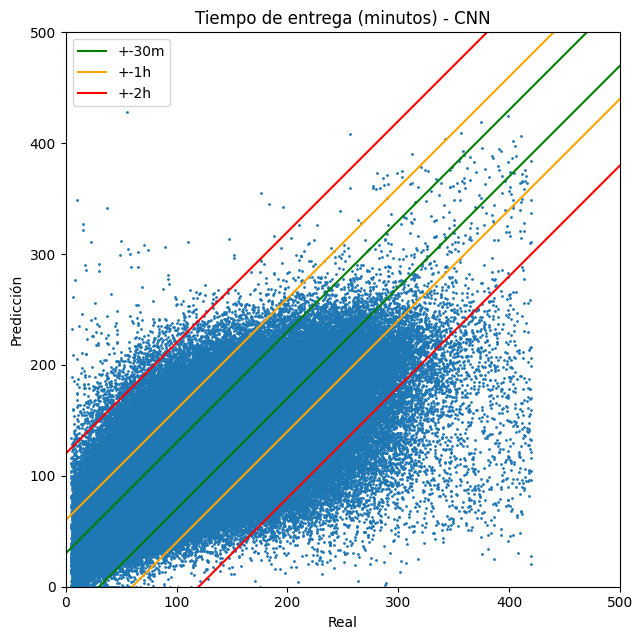

In [34]:
# Predicciones (CNN)
y_pred = model_cnn.predict(X_test, verbose=0)
plot_predictions(y_test, y_pred, "CNN")

In [35]:
# Distribución de errores (CNN)
y_pred = np.array(y_pred).reshape(-1)
error = y_pred - y_test
plt.hist(error, bins = 25)
plt.xlabel("Error de predicción (minutos)")
_ = plt.ylabel("Frecuencia")

In [36]:
# Muestra porcentaje de acierto en rangos de +-15, +-30, +-1h y +-2h (CNN)
accuracy(error)

Precisión:
+-15m: 22.9%
+-30m: 42.7%
+-1h : 70.9%
+-2h : 94.5%


### 3.4 ALEXNET

In [36]:
# Definición de un modelo convolucional (AlexNet)
def build_model_an():
    model = keras.Sequential([
        keras.Input(shape=(train_steps, 1)),
        layers.Conv1D(filters=96, kernel_size=7, activation='relu', padding='same', name='Conv1D_1'),
        layers.Conv1D(filters=256, kernel_size=5, activation='relu', padding='same', name='Conv1D_2'),
        layers.MaxPooling1D(pool_size=2, padding='same', name='MaxPooling1D_2'),
        layers.Conv1D(filters=384, kernel_size=3, activation='relu', padding='same', name='Conv1D_3'),
        layers.Conv1D(filters=384, kernel_size=3, activation='relu', padding='same', name='Conv1D_4'),
        layers.Conv1D(filters=384, kernel_size=3, activation='relu', padding='same', name='Conv1D_5'),
        layers.MaxPooling1D(pool_size=2, padding='same', name='MaxPooling1D_3'),
        layers.Flatten(name='Flatten'),
        layers.Dense(384, activation='relu', name='Dense_1'),
        layers.Dense(384, activation='relu', name='Dense_2'),
        layers.Dense(1, activation='relu', name='Dense_3')
    ], name="AlexNet")

    optimizer = tf.keras.optimizers.RMSprop(0.002)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse', 'root_mean_squared_error', 'r2_score'])

    return model

In [37]:
# Construcción del modelo (AlexNet)
model_an = build_model_an()
model_an.summary()

Model: "AlexNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1D_1 (Conv1D)               │ (None, 21, 96)         │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D_2 (Conv1D)               │ (None, 21, 256)        │       123,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling1D_2 (MaxPooling1D)   │ (None, 11, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D_3 (Conv1D)               │ (None, 11, 384)        │       295,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D_4 (Conv1D)               │ (None, 11, 384)        │       442,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D_5 (Conv1D)               │ (None, 11, 384)        │       442,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling1D_3 (MaxPooling1D)   │ (None, 6, 384)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 384)            │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 384)            │       147,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_3 (Dense)                 │ (None, 1)              │           385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,338,049 (8.92 MB)

 Trainable params: 2,338,049 (8.92 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Entrenamiento del modelo (AlexNet)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history_an = model_an.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, verbose=2, callbacks=[early_stop])

Epoch 1/1000
8065/8065 - 189s - 23ms/step - loss: 5973.9209 - mae: 57.9080 - mse: 5973.9209 - r2_score: 0.0372 - root_mean_squared_error: 77.2911 - val_loss: 4261.8887 - val_mae: 52.2259 - val_mse: 4261.8887 - val_r2_score: 0.3096 - val_root_mean_squared_error: 65.2831
Epoch 2/1000
8065/8065 - 187s - 23ms/step - loss: 4282.6094 - mae: 51.6847 - mse: 4282.6094 - r2_score: 0.3098 - root_mean_squared_error: 65.4417 - val_loss: 4257.0728 - val_mae: 50.5641 - val_mse: 4257.0728 - val_r2_score: 0.3104 - val_root_mean_squared_error: 65.2462
Epoch 3/1000
8065/8065 - 187s - 23ms/step - loss: 3987.0596 - mae: 49.4724 - mse: 3987.0596 - r2_score: 0.3574 - root_mean_squared_error: 63.1432 - val_loss: 4431.2974 - val_mae: 53.0729 - val_mse: 4431.2974 - val_r2_score: 0.2822 - val_root_mean_squared_error: 66.5680
Epoch 4/1000
8065/8065 - 185s - 23ms/step - loss: 3856.4980 - mae: 48.4810 - mse: 3856.4980 - r2_score: 0.3785 - root_mean_squared_error: 62.1007 - val_loss: 4871.2319 - val_mae: 56.6426 - v

In [39]:
# Muestra el progreso del entrenamiento (AlexNet)
hist = pd.DataFrame(history_an.history)
hist['epoch'] = history_an.epoch
hist.tail()

loss        mae          mse  r2_score  root_mean_squared_error     val_loss    val_mae      val_mse  val_r2_score  val_root_mean_squared_error  epoch
22  3509.070312  45.860386  3509.070312  0.434470                59.237408  3591.895996  46.052673  3591.895996      0.418138                    59.932430     22
23  3500.096680  45.781021  3500.096680  0.435910                59.161613  3522.330811  46.713066  3522.330811      0.429407                    59.349228     23
24  3489.387207  45.677788  3489.387207  0.437637                59.071033  3670.730957  46.300079  3670.730957      0.405367                    60.586559     24
25  3483.123779  45.659145  3483.123779  0.438645                59.017994  3564.931885  46.197491  3564.931885      0.422506                    59.707050     25
26  3470.971436  45.524372  3470.971436  0.440606                58.914951  4001.042969  47.991055  4001.042969      0.351859                    63.253799     26

In [40]:
# Gráficas del entrenamiento (AlexNet)
plot_history(history_an, "AlexNet")

In [41]:
# Probamos con el conjunto de test (AlexNet)
loss, mae, mse, rmse, r2 = model_an.evaluate(X_test, y_test, verbose=2)
resultados(mae, rmse, r2)

4321/4321 - 27s - 6ms/step - loss: 4897.4570 - mae: 52.8280 - mse: 4897.4570 - r2_score: 0.2087 - root_mean_squared_error: 69.9818

MAE: 52.83 minutos
RMSE: 69.98 minutos
R2:  0.21


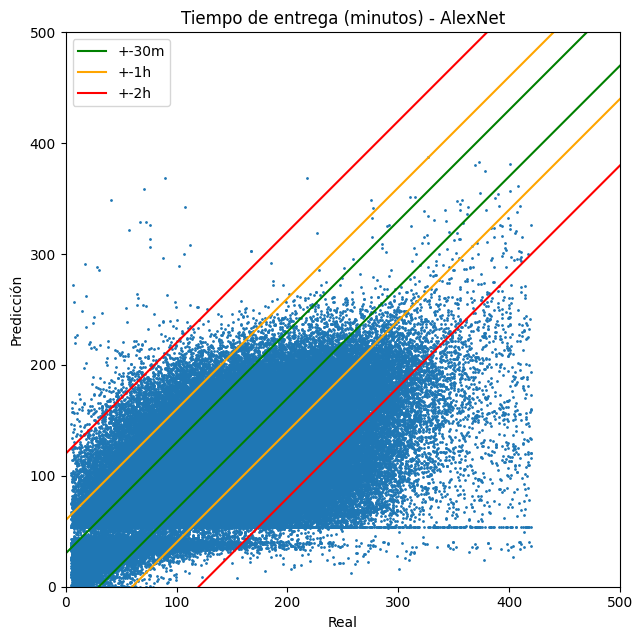

In [42]:
# Predicciones (AlexNet)
y_pred = model_an.predict(X_test, verbose=0)
plot_predictions(y_test, y_pred, "AlexNet")

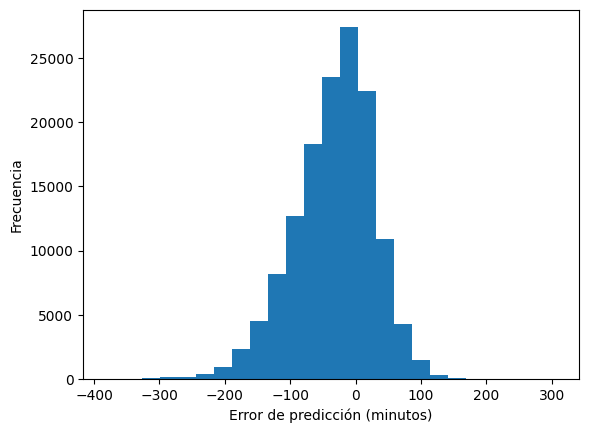

In [43]:
# Distribución de errores (AlexNet)
y_pred = np.array(y_pred).reshape(-1)
error = y_pred - y_test
plt.hist(error, bins = 25)
plt.xlabel("Error de predicción (minutos)")
_ = plt.ylabel("Frecuencia")

In [44]:
# Muestra porcentaje de acierto en rangos de +-15, +-30, +-1h y +-2h (AlexNet)
accuracy(error)

Precisión:
+-15m: 21.1%
+-30m: 39.5%
+-1h : 65.6%
+-2h : 90.9%


### 3.5 VGG16

In [18]:
# Definición de un modelo convolucional (VGG16)
def build_model_vgg():
    model = keras.Sequential([
        keras.Input(shape=(train_steps, 1)),
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name='Conv1D_1'),
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name='Conv1D_2'),
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name='Conv1D_3'),
        layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', name='Conv1D_4'),
        layers.MaxPooling1D(pool_size=2, padding='same', name='MaxPooling1D_1'),
        layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same', name='Conv1D_5'),
        layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same', name='Conv1D_6'),
        layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same', name='Conv1D_7'),
        layers.MaxPooling1D(pool_size=2, padding='same', name='MaxPooling1D_2'),
        layers.Conv1D(filters=512, kernel_size=3, activation='relu', padding='same', name='Conv1D_8'),
        layers.Conv1D(filters=512, kernel_size=3, activation='relu', padding='same', name='Conv1D_9'),
        layers.Conv1D(filters=512, kernel_size=3, activation='relu', padding='same', name='Conv1D_10'),
        layers.MaxPooling1D(pool_size=2, padding='same', name='MaxPooling1D_3'),
        layers.Flatten(name='Flatten'),
        layers.Dense(384, activation='relu', name='Dense_1'),
        layers.Dense(384, activation='relu', name='Dense_2'),
        layers.Dense(1, activation='linear', name='Dense_3')
    ], name="VGG16")

    optimizer = tf.keras.optimizers.RMSprop(0.002)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse', 'root_mean_squared_error', 'r2_score'])

    return model

In [19]:
# Construcción del modelo (VGG16)
model_vgg = build_model_vgg()
model_vgg.summary()

Model: "VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1D_3 (Conv1D)               │ (None, 21, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D_4 (Conv1D)               │ (None, 21, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D_5 (Conv1D)               │ (None, 21, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling1D_2 (MaxPooling1D)   │ (None, 11, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D_8 (Conv1D)               │ (None, 11, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D_9 (Conv1D)               │ (None, 11, 512)        │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D_10 (Conv1D)              │ (None, 11, 512)        │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling1D_3 (MaxPooling1D)   │ (None, 6, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 384)            │     1,180,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 384)            │       147,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_3 (Dense)                 │ (None, 1)              │           385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,419,393 (13.04 MB)

 Trainable params: 3,419,393 (13.04 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Entrenamiento del modelo (VGG16)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history_vgg = model_vgg.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, verbose=2, callbacks=[early_stop])

Epoch 1/1000
8065/8065 - 343s - 43ms/step - loss: 25347.1191 - mae: 58.4045 - mse: 25347.1191 - r2_score: -3.0941e+00 - root_mean_squared_error: 159.2078 - val_loss: 4501.3647 - val_mae: 53.4080 - val_mse: 4501.3647 - val_r2_score: 0.2731 - val_root_mean_squared_error: 67.0922
Epoch 2/1000
8065/8065 - 288s - 36ms/step - loss: 4078.5796 - mae: 50.1223 - mse: 4078.5796 - r2_score: 0.3412 - root_mean_squared_error: 63.8638 - val_loss: 4420.2817 - val_mae: 50.4409 - val_mse: 4420.2817 - val_r2_score: 0.2862 - val_root_mean_squared_error: 66.4852
Epoch 3/1000
8065/8065 - 291s - 36ms/step - loss: 3882.1416 - mae: 48.7430 - mse: 3882.1416 - r2_score: 0.3730 - root_mean_squared_error: 62.3068 - val_loss: 5667.6196 - val_mae: 56.6050 - val_mse: 5667.6196 - val_r2_score: 0.0848 - val_root_mean_squared_error: 75.2836
Epoch 4/1000
8065/8065 - 290s - 36ms/step - loss: 3801.0020 - mae: 48.1470 - mse: 3801.0020 - r2_score: 0.3861 - root_mean_squared_error: 61.6523 - val_loss: 3761.0808 - val_mae: 47.

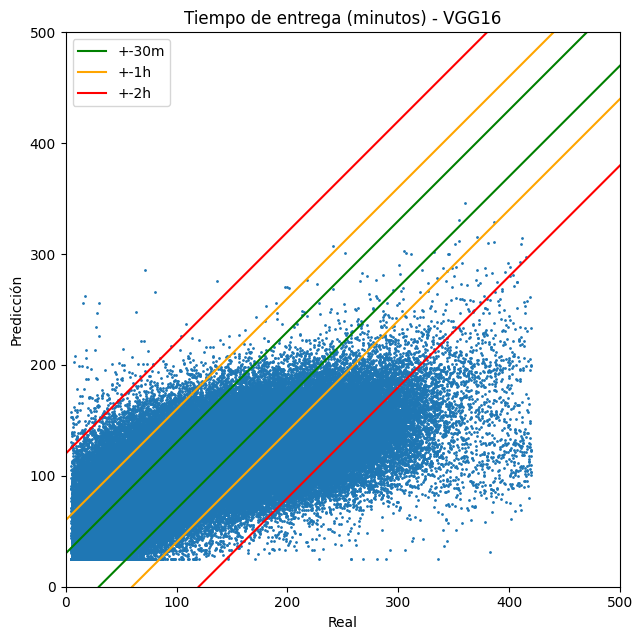

In [23]:
# Predicciones (modelo VGG16)
y_pred = model_vgg.predict(X_test, verbose=0)
plot_predictions(y_test, y_pred, "VGG16")

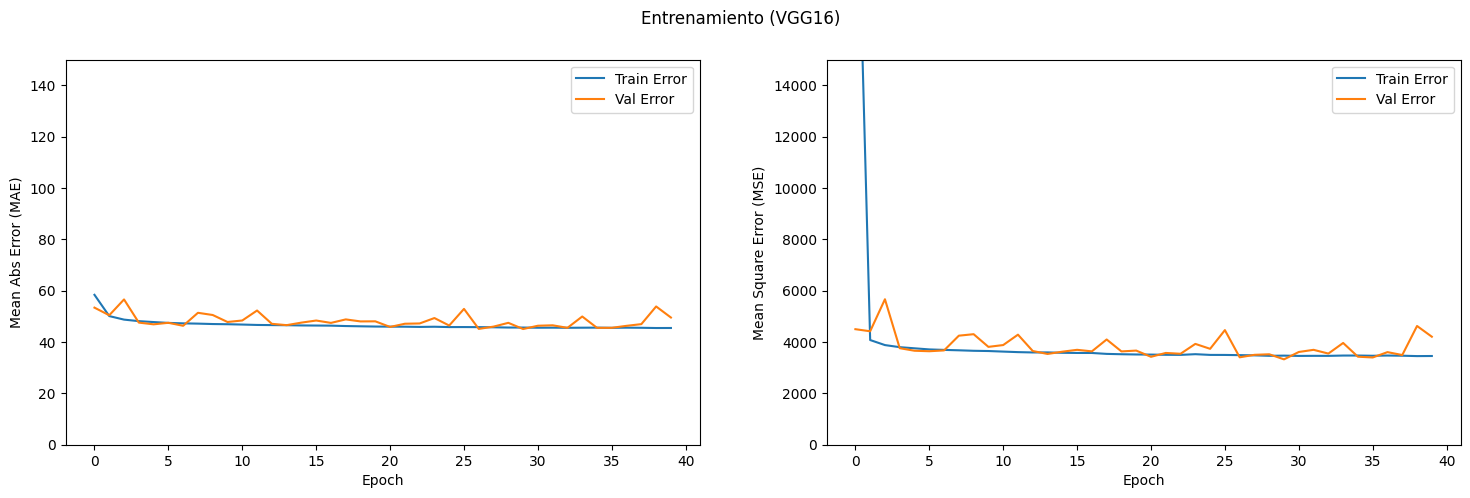

In [24]:
# Gráficas del entrenamiento (VGG16)
plot_history(history_vgg, "VGG16")

In [25]:
# Probamos con el conjunto de test (VGG16)
loss, mae, mse, rmse, r2 = model_vgg.evaluate(X_test, y_test, verbose=2)
resultados(mae, rmse, r2)

4321/4321 - 35s - 8ms/step - loss: 4469.6777 - mae: 51.0316 - mse: 4469.6777 - r2_score: 0.2798 - root_mean_squared_error: 66.8557

MAE: 51.03 minutos
RMSE: 66.86 minutos
R2:  0.28


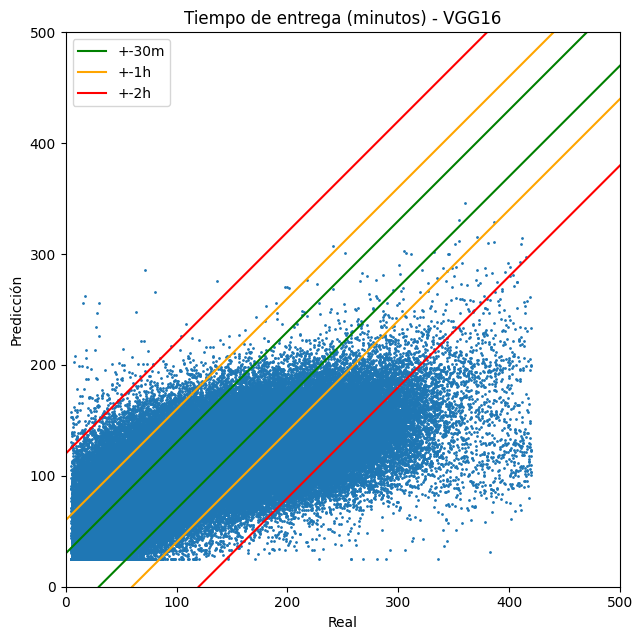

In [26]:
# Predicciones (VGG16)
y_pred = model_vgg.predict(X_test, verbose=0)
plot_predictions(y_test, y_pred, "VGG16")

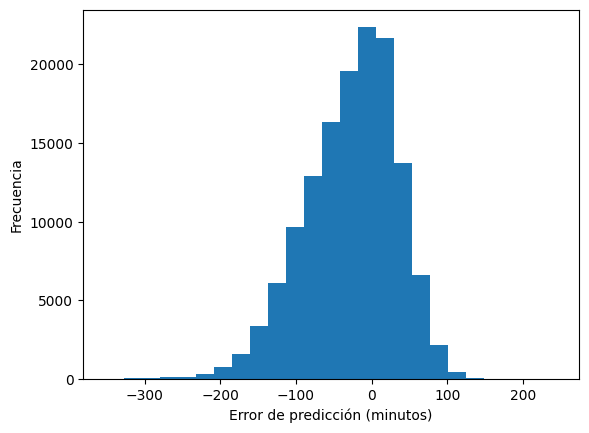

In [27]:
# Distribución de errores (VGG16)
y_pred = np.array(y_pred).reshape(-1)
error = y_pred - y_test
plt.hist(error, bins = 25)
plt.xlabel("Error de predicción (minutos)")
_ = plt.ylabel("Frecuencia")

In [28]:
# # Muestra porcentaje de acierto en rangos de +-15, +-30, +-1h y +-2h (VGG16)
accuracy(error)

Precisión:
+-15m: 20.9%
+-30m: 39.4%
+-1h : 67.0%
+-2h : 92.3%
